In [ ]:
# ===============================================================
# APTOS Degradation + SR Enhancement Pipeline (Clinically Matched)
# Author: Jonathan Morel | 2025
# ===============================================================

import os
import math
from pathlib import Path
from io import BytesIO

import numpy as np
import pandas as pd
from PIL import Image, ImageFilter

from skimage.metrics import peak_signal_noise_ratio as psnr_metric

# ===============================================================
# CONFIGURATION
# ===============================================================
BASE_PATH = Path(r"C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS")
ORIG_DIR = BASE_PATH / "train_ready_512"
DEG_DIR = BASE_PATH / "1. Degraded_x2_true"

SR_ROOT = Path(r"C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full")
SR_MODELS_DIR = Path(r"C:/Users/Jonathan Morel/Desktop/Honour/outputs/sr_models")

SCALE = 2
BLUR_SIGMA = 0.8
NOISE_STD = 0.01

VALID_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}


def list_images(root: Path):
    return [p for p in Path(root).rglob("*") if p.suffix.lower() in VALID_EXTS]


def ensure_parent(p: Path):
    p.parent.mkdir(parents=True, exist_ok=True)


def psnr_uint8(a, b):
    a = a.astype(np.float32)
    b = b.astype(np.float32)
    mse = np.mean((a - b) ** 2)
    if mse == 0:
        return float("inf")
    return 20.0 * math.log10(255.0 / math.sqrt(mse))


# ===============================================================
# DEGRADATION PIPELINE
# ===============================================================
def degrade_one(img: Image.Image, scale: int, blur_sigma: float, noise_std: float):
    w, h = img.size
    dw, dh = max(int(w / scale), 128), max(int(h / scale), 128)
    dw, dh = min(dw, w - 1), min(dh, h - 1)

    # Downsample + upsample
    out = img.resize((dw, dh), resample=Image.BICUBIC).resize((w, h), resample=Image.BICUBIC)

    # Gaussian blur
    if blur_sigma > 0:
        out = out.filter(ImageFilter.GaussianBlur(radius=float(blur_sigma)))

    # Add Gaussian noise
    if noise_std > 0:
        arr = np.array(out).astype(np.float32)
        arr += np.random.normal(0.0, noise_std * 255.0, arr.shape).astype(np.float32)
        arr = np.clip(arr, 0, 255).astype(np.uint8)
        out = Image.fromarray(arr)

    return out


# ===============================================================
# RUN DEGRADATION
# ===============================================================
def run_degradation():
    deg_root = DEG_DIR
    deg_root.mkdir(parents=True, exist_ok=True)

    files = list_images(ORIG_DIR)
    print(f"[APTOS-DEGRADE] Found {len(files)} images")

    rows = []
    for i, p in enumerate(files, 1):
        try:
            img = Image.open(p).convert("RGB")
            out = Path(deg_root, p.relative_to(ORIG_DIR))
            ensure_parent(out)

            dimg = degrade_one(img, SCALE, BLUR_SIGMA, NOISE_STD)
            dimg.save(out)

            ps = psnr_uint8(np.array(img), np.array(dimg))
            rows.append([str(p), str(out), img.size[0], img.size[1], f"{ps:.4f}"])

            if i % 50 == 0:
                print(f"[APTOS-DEGRADE] {i}/{len(files)} done")
        except Exception as e:
            print(f"[WARN] {p}: {e!r}")

    mf = deg_root / "manifest_degraded.csv"
    df = pd.DataFrame(
        rows,
        columns=["input_path", "output_path", "width", "height", "psnr_vs_original"],
    )
    df["scale"] = SCALE
    df["blur_sigma"] = BLUR_SIGMA
    df["noise_std"] = NOISE_STD
    df.to_csv(mf, index=False)
    print(f"[DONE] Manifest written → {mf}")


[APTOS-DEGRADE] Found 3662 images
[APTOS-DEGRADE] 50/3662 done
[APTOS-DEGRADE] 100/3662 done
[APTOS-DEGRADE] 150/3662 done
[APTOS-DEGRADE] 200/3662 done
[APTOS-DEGRADE] 250/3662 done
[APTOS-DEGRADE] 300/3662 done
[APTOS-DEGRADE] 350/3662 done
[APTOS-DEGRADE] 400/3662 done
[APTOS-DEGRADE] 450/3662 done
[APTOS-DEGRADE] 500/3662 done
[APTOS-DEGRADE] 550/3662 done
[APTOS-DEGRADE] 600/3662 done
[APTOS-DEGRADE] 650/3662 done
[APTOS-DEGRADE] 700/3662 done
[APTOS-DEGRADE] 750/3662 done
[APTOS-DEGRADE] 800/3662 done
[APTOS-DEGRADE] 850/3662 done
[APTOS-DEGRADE] 900/3662 done
[APTOS-DEGRADE] 950/3662 done
[APTOS-DEGRADE] 1000/3662 done
[APTOS-DEGRADE] 1050/3662 done
[APTOS-DEGRADE] 1100/3662 done
[APTOS-DEGRADE] 1150/3662 done
[APTOS-DEGRADE] 1200/3662 done
[APTOS-DEGRADE] 1250/3662 done
[APTOS-DEGRADE] 1300/3662 done
[APTOS-DEGRADE] 1350/3662 done
[APTOS-DEGRADE] 1400/3662 done
[APTOS-DEGRADE] 1450/3662 done
[APTOS-DEGRADE] 1500/3662 done
[APTOS-DEGRADE] 1550/3662 done
[APTOS-DEGRADE] 1600/3662

ModuleNotFoundError: No module named 'src'

In [9]:
# ===============================================================
# APTOS SR Enhancement Pipeline (Clinically Matched)
# Author: Jonathan Morel | 2025
# ===============================================================

import sys, os, importlib.util
from pathlib import Path

# --- Set working directory to project root (contains "src") ---
project_root = Path(r"C:/Users/Jonathan Morel/Desktop/Honour")
os.chdir(project_root)

# --- Add "src" to sys.path for module discovery ---
SRC_PATH = project_root / "src"
if not SRC_PATH.exists():
    raise FileNotFoundError(f"Cannot find src folder at {SRC_PATH}")

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

print(f"Working directory set to: {project_root}")
print(f"Added to sys.path: {SRC_PATH}")

# --- Import export_sr directly (bypassing ZSL / CLIP imports) ---
export_sr_path = SRC_PATH / "inference" / "export_sr.py"
spec = importlib.util.spec_from_file_location("export_sr", export_sr_path)
export_sr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(export_sr)
export_sr_main = export_sr.main

# ===============================================================
# CONFIGURATION
# ===============================================================
BASE_PATH = Path(r"C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS")
ORIG_DIR = BASE_PATH / "train_ready_512"
DEG_DIR = BASE_PATH / "1. Degraded_x2_true"

SR_ROOT = Path(r"C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full")
SR_MODELS_DIR = Path(r"C:/Users/Jonathan Morel/Desktop/Honour/outputs/sr_models")

VALID_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}


def list_images(root: Path):
    return [p for p in Path(root).rglob("*") if p.suffix.lower() in VALID_EXTS]


# ===============================================================
# SR ENHANCEMENT ONLY
# ===============================================================
def run_sr_enhancement():
    MODELS = ["espcn", "fsrcnn", "srcnn"]
    pairs = [("original_true", ORIG_DIR), ("degraded_true", DEG_DIR)]

    for model in MODELS:
        ckpt = SR_MODELS_DIR / f"{model}_best.pt"
        if not ckpt.exists():
            print(f"[SKIP] Missing checkpoint for {model}")
            continue

        for tag, src_dir in pairs:
            imgs = list_images(src_dir)
            if not imgs:
                print(f"[SKIP] No images under {src_dir}")
                continue

            out_dir = SR_ROOT / f"{model}_x2_{tag}_aptos"
            out_dir.mkdir(parents=True, exist_ok=True)

            print(f"→ Running {model.upper()} on {tag} ({len(imgs)} images)")
            try:
                export_sr_main(
                    [
                        "--config",
                        "config.yaml",
                        "--model",
                        model,
                        "--ckpt",
                        str(ckpt),
                        "--images",
                        str(src_dir),
                        "--out",
                        str(out_dir),
                        "--degrade_scale",
                        "1",
                        "--skip_existing",
                    ]
                )
            except Exception as e:
                print(f"[ERROR] {model} {tag}: {e!r}")

    print("SR enhancement complete for APTOS (original + degraded)")


# ===============================================================
# MAIN EXECUTION
# ===============================================================
if __name__ == "__main__":
    run_sr_enhancement()
    print("All tasks complete - APTOS SR enhancement finished.")


Working directory set to: C:\Users\Jonathan Morel\Desktop\Honour
Added to sys.path: C:\Users\Jonathan Morel\Desktop\Honour\src
→ Running ESPCN on original_true (3662 images)
[export_sr] device=cuda


[Export:espcn x1]: 100%|██████████| 3662/3662 [04:26<00:00, 13.75it/s, last_s=0.01, avg_s=0.00, eta_m=0.0]


Export finished → C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn_x2_original_true_aptos\espcn_x1
Timings saved → outputs\metrics\export_times_espcn_x1.csv
Manifest saved → C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn_x2_original_true_aptos\manifest_espcn_x1.csv
→ Running ESPCN on degraded_true (3662 images)
[export_sr] device=cuda


[Export:espcn x1]: 100%|██████████| 3662/3662 [04:44<00:00, 12.89it/s, last_s=0.00, avg_s=0.00, eta_m=0.0]


Export finished → C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn_x2_degraded_true_aptos\espcn_x1
Timings saved → outputs\metrics\export_times_espcn_x1.csv
Manifest saved → C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn_x2_degraded_true_aptos\manifest_espcn_x1.csv
→ Running FSRCNN on original_true (3662 images)
[export_sr] device=cuda


[Export:fsrcnn x1]: 100%|██████████| 3662/3662 [04:47<00:00, 12.72it/s, last_s=0.01, avg_s=0.01, eta_m=0.0]


Export finished → C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn_x2_original_true_aptos\fsrcnn_x1
Timings saved → outputs\metrics\export_times_fsrcnn_x1.csv
Manifest saved → C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn_x2_original_true_aptos\manifest_fsrcnn_x1.csv
→ Running FSRCNN on degraded_true (3662 images)
[export_sr] device=cuda


[Export:fsrcnn x1]: 100%|██████████| 3662/3662 [04:27<00:00, 13.67it/s, last_s=0.01, avg_s=0.01, eta_m=0.0]


Export finished → C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn_x2_degraded_true_aptos\fsrcnn_x1
Timings saved → outputs\metrics\export_times_fsrcnn_x1.csv
Manifest saved → C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn_x2_degraded_true_aptos\manifest_fsrcnn_x1.csv
→ Running SRCNN on original_true (3662 images)
[export_sr] device=cuda


[Export:srcnn x1]: 100%|██████████| 3662/3662 [04:45<00:00, 12.84it/s, last_s=0.00, avg_s=0.01, eta_m=0.0]


Export finished → C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn_x2_original_true_aptos\srcnn_x1
Timings saved → outputs\metrics\export_times_srcnn_x1.csv
Manifest saved → C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn_x2_original_true_aptos\manifest_srcnn_x1.csv
→ Running SRCNN on degraded_true (3662 images)
[export_sr] device=cuda


[Export:srcnn x1]: 100%|██████████| 3662/3662 [04:46<00:00, 12.78it/s, last_s=0.01, avg_s=0.01, eta_m=0.0]

Export finished → C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn_x2_degraded_true_aptos\srcnn_x1
Timings saved → outputs\metrics\export_times_srcnn_x1.csv
Manifest saved → C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn_x2_degraded_true_aptos\manifest_srcnn_x1.csv
SR enhancement complete for APTOS (original + degraded)
All tasks complete - APTOS SR enhancement finished.


# Path Verifications

In [30]:
import os
from pathlib import Path
import pandas as pd

# ============================================================
# CONFIGURE ROOT DIRECTORIES
# ============================================================
APTOS_ROOT = Path("C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS")
IDRID_ROOT = Path("C:/Users/Jonathan Morel/Desktop/Honour/Data/IDRID")

SR_APTOS = Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full")
SR_IDRID = Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/IDRID_SR_full")

VALID_EXT = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}


def list_images(p):
    return [x for x in p.rglob("*") if x.suffix.lower() in VALID_EXT]


# ============================================================
# CONDITION → PATH MAPPING
# ============================================================
def get_condition_paths_APTOS():
    SR_APTOS = Path(r"C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full")

    return {
        # Raw images
        "original": Path(r"C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS/train_ready_512"),
        "degraded": Path(r"C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS/1. Degraded_x2_true"),

        # Bicubic baselines (choose ESPCN folders; identical to others)
        "bicubic_original": SR_APTOS / "espcn_x2_original_true_aptos" / "bicubic_x1",
        "bicubic_degraded": SR_APTOS / "espcn_x2_degraded_true_aptos" / "bicubic_x1",

        # SR models
        "espcn_original":  SR_APTOS / "espcn_x2_original_true_aptos" / "espcn_x1",
        "espcn_degraded":  SR_APTOS / "espcn_x2_degraded_true_aptos" / "espcn_x1",

        "fsrcnn_original": SR_APTOS / "fsrcnn_x2_original_true_aptos" / "fsrcnn_x1",
        "fsrcnn_degraded": SR_APTOS / "fsrcnn_x2_degraded_true_aptos" / "fsrcnn_x1",

        "srcnn_original":  SR_APTOS / "srcnn_x2_original_true_aptos" / "srcnn_x1",
        "srcnn_degraded":  SR_APTOS / "srcnn_x2_degraded_true_aptos" / "srcnn_x1",
    }



def get_condition_paths_IDRID():
    IDRID_ROOT = Path(r"C:/Users/Jonathan Morel/Desktop/Honour/Data/B. Disease Grading")
    SR_IDRID = Path(r"C:/Users/Jonathan Morel/Desktop/Honour/outputs/sr_images_v2")

    return {
        # Raw images
        "original": IDRID_ROOT / "1. Original Images",
        "degraded": IDRID_ROOT / "1. Degraded_x2",

        # Bicubic (choose ESPCN baseline)
        "bicubic_original": SR_IDRID / "espcn_x2_original" / "bicubic_x1",
        "bicubic_degraded": SR_IDRID / "espcn_x2_degraded" / "bicubic_x1",

        # SR models
        "espcn_original": SR_IDRID / "espcn_x2_original" / "espcn_x1",
        "espcn_degraded": SR_IDRID / "espcn_x2_degraded" / "espcn_x1",

        "fsrcnn_original": SR_IDRID / "fsrcnn_x2_original" / "fsrcnn_x1",
        "fsrcnn_degraded": SR_IDRID / "fsrcnn_x2_degraded" / "fsrcnn_x1",

        "srcnn_original": SR_IDRID / "srcnn_x2_original" / "srcnn_x1",
        "srcnn_degraded": SR_IDRID / "srcnn_x2_degraded" / "srcnn_x1",
    }



# ============================================================
# VERIFICATION FUNCTION
# ============================================================
def verify_dataset(name, mapping):
    print(f"\n============================")
    print(f"Verifying {name}")
    print(f"============================")

    report_rows = []

    # Count images in each condition
    for condition, path in mapping.items():
        if not path.exists():
            print(f"[MISSING FOLDER] {condition}: {path}")
            count = 0
        else:
            count = len(list_images(path))
            print(f"{condition:<20} → {count:>5} images")

        report_rows.append([condition, str(path), count])

    # Build report
    df = pd.DataFrame(report_rows, columns=["condition", "path", "count"])
    return df


# ============================================================
# RUN VERIFICATION
# ============================================================
aptos_map = get_condition_paths_APTOS()
idrid_map = get_condition_paths_IDRID()

df_aptos = verify_dataset("APTOS", aptos_map)
df_idrid = verify_dataset("IDRID", idrid_map)

print("\nVerification complete.")



Verifying APTOS
original             →  3662 images
degraded             →  3662 images
bicubic_original     →  3662 images
bicubic_degraded     →  3662 images
espcn_original       →  3662 images
espcn_degraded       →  3662 images
fsrcnn_original      →  3662 images
fsrcnn_degraded      →  3662 images
srcnn_original       →  3662 images
srcnn_degraded       →  3662 images

Verifying IDRID
original             →   516 images
degraded             →   516 images
bicubic_original     →   413 images
bicubic_degraded     →   413 images
espcn_original       →   413 images
espcn_degraded       →   413 images
fsrcnn_original      →   413 images
fsrcnn_degraded      →   413 images
srcnn_original       →   413 images
srcnn_degraded       →   413 images

Verification complete.


In [29]:
from pathlib import Path

VALID = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def count_imgs(path: Path):
    return sum(1 for f in path.rglob("*") if f.suffix.lower() in VALID)

def explore(root: Path, max_depth=3, indent=0):
    """Recursively prints folders + image counts down to `max_depth`."""
    if indent == 0:
        print(f"\n📁 ROOT: {root}")
        print("=" * 70)

    if not root.exists():
        print(" " * indent + f"[MISSING] {root}")
        return

    for entry in sorted(root.iterdir()):
        if entry.is_dir():
            img_count = count_imgs(entry)
            print(" " * indent + f"- {entry.name:40} | {img_count} images")

            # If we haven't reached max depth, continue
            if indent // 4 + 1 < max_depth:
                explore(entry, max_depth=max_depth, indent=indent+4)

def run_all():
    roots = [
        ("APTOS RAW", Path(r"C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS")),
        ("IDRID RAW", Path(r"C:/Users/Jonathan Morel/Desktop/Honour/Data/B. Disease Grading")),
        ("APTOS SR OUTPUTS", Path(r"C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full")),
        ("IDRID SR OUTPUTS FULL", Path(r"C:/Users/Jonathan Morel/Desktop/Honour/outputs/sr_images_full_516")),
        ("IDRID SR (OLDER)", Path(r"C:/Users/Jonathan Morel/Desktop/Honour/outputs/sr_images_v2")),
    ]

    for label, root in roots:
        print(f"\n====================================")
        print(f"SUMMARY: {label}")
        print("====================================")
        explore(root, max_depth=4)

# Run
run_all()



SUMMARY: APTOS RAW

📁 ROOT: C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS
- 1. Degraded_x2                           | 3662 images
    - 0                                        | 1805 images
    - 1                                        | 370 images
    - 2                                        | 999 images
    - 3                                        | 193 images
    - 4                                        | 295 images
- 1. Degraded_x2_true                      | 3662 images
    - 0                                        | 1805 images
    - 1                                        | 370 images
    - 2                                        | 999 images
    - 3                                        | 193 images
    - 4                                        | 295 images
- test_images                              | 1928 images
- train_images                             | 3662 images
- train_ready_512                          | 3662 images
    - 0                           

In [ ]:
import os
from pathlib import Path
from PIL import Image

PATHS = {
    "APTOS": {
        "original": Path("C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS/train_ready_512"),
        "degraded": Path("C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS/1. Degraded_x2_true"),

        "bicubic_original": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full/espcn_x2_original_true_aptos/bicubic_x1"),
        "bicubic_degraded": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full/espcn_x2_degraded_true_aptos/bicubic_x1"),

        "espcn_original": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full/espcn_x2_original_true_aptos/espcn_x1"),
        "espcn_degraded": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full/espcn_x2_degraded_true_aptos/espcn_x1"),

        "fsrcnn_original": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full/fsrcnn_x2_original_true_aptos/fsrcnn_x1"),
        "fsrcnn_degraded": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full/fsrcnn_x2_degraded_true_aptos/fsrcnn_x1"),

        "srcnn_original": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full/srcnn_x2_original_true_aptos/srcnn_x1"),
        "srcnn_degraded": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full/srcnn_x2_degraded_true_aptos/srcnn_x1"),
    },

    "IDRID": {
        "original": Path("C:/Users/Jonathan Morel/Desktop/Honour/Data/B. Disease Grading/1. Original Images"),
        "degraded": Path("C:/Users/Jonathan Morel/Desktop/Honour/Data/B. Disease Grading/1. Degraded_x2"),

        "bicubic_original": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/sr_images_v2/espcn_x2_original/bicubic_x1"),
        "bicubic_degraded": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/sr_images_v2/espcn_x2_degraded/bicubic_x1"),

        "espcn_original": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/sr_images_v2/espcn_x2_original/espcn_x1"),
        "espcn_degraded": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/sr_images_v2/espcn_x2_degraded/espcn_x1"),

        "fsrcnn_original": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/sr_images_v2/fsrcnn_x2_original/fsrcnn_x1"),
        "fsrcnn_degraded": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/sr_images_v2/fsrcnn_x2_degraded/fsrcnn_x1"),

        "srcnn_original": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/sr_images_v2/srcnn_x2_original/srcnn_x1"),
        "srcnn_degraded": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/sr_images_v2/srcnn_x2_degraded/srcnn_x1"),
    },
}

VALID_EXT = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def list_images(folder):
    return sorted([f for f in folder.rglob("*") if f.suffix.lower() in VALID_EXT])

def check_folder_exists(name, path):
    if not path.exists():
        print(f"[Missing] {name}: {path}")
        return False
    return True

def check_filenames(base, compare, label):
    base_names = {f.name for f in base}
    compare_names = {f.name for f in compare}

    print(f"{label}")
    print(f"Missing files: {len(base_names - compare_names)}")
    print(f"Extra files: {len(compare_names - base_names)}")

def check_dimensions(path, expected_size, label):
    images = list_images(path)
    mismatches = []
    for im in images:
        try:
            with Image.open(im) as img:
                if img.size != expected_size:
                    mismatches.append((im.name, img.size))
        except:
            mismatches.append((im.name, "Unreadable"))

    print(f"{label}: incorrect size files: {len(mismatches)}")

def validate_dataset(name):
    print("")
    print("====================================")
    print(f"{name} VALIDATION")
    print("====================================")

    paths = PATHS[name]

    original_path = paths["original"]
    if not check_folder_exists("original", original_path):
        return

    original_images = list_images(original_path)
    print(f"Original count: {len(original_images)}")

    if not original_images:
        print("Original folder is empty. Check path.")
        return

    with Image.open(original_images[0]) as img:
        expected_size = img.size

    for key, p in paths.items():
        if key == "original":
            continue

        if check_folder_exists(key, p):
            imgs = list_images(p)
            check_filenames(original_images, imgs, f"Comparing original and {key}")
            check_dimensions(p, expected_size, f"{key}")

    print(f"{name} validation complete")

validate_dataset("APTOS")
validate_dataset("IDRID")



APTOS VALIDATION
Original count: 3662
Comparing original and degraded
Missing files: 0
Extra files: 0
degraded: incorrect size files: 0
Comparing original and bicubic_original
Missing files: 0
Extra files: 0
bicubic_original: incorrect size files: 0
Comparing original and bicubic_degraded
Missing files: 0
Extra files: 0
bicubic_degraded: incorrect size files: 0
Comparing original and espcn_original
Missing files: 0
Extra files: 0
espcn_original: incorrect size files: 0
Comparing original and espcn_degraded
Missing files: 0
Extra files: 0
espcn_degraded: incorrect size files: 0
Comparing original and fsrcnn_original
Missing files: 0
Extra files: 0
fsrcnn_original: incorrect size files: 0
Comparing original and fsrcnn_degraded
Missing files: 0
Extra files: 0
fsrcnn_degraded: incorrect size files: 0
Comparing original and srcnn_original
Missing files: 0
Extra files: 0
srcnn_original: incorrect size files: 1
Comparing original and srcnn_degraded
Missing files: 0
Extra files: 0


# SR Results

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# ===============================================================
# CONFIGURE PATHS
# ===============================================================
APTOS_ORIG = Path("C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS/train_ready_512")
APTOS_DEG  = Path("C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS/1. Degraded_x2_true")

SR_APTOS = Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full")

IDRID_ORIG = Path("C:/Users/Jonathan Morel/Desktop/Honour/Data/B. Disease Grading/1. Original Images")
IDRID_DEG  = Path("C:/Users/Jonathan Morel/Desktop/Honour/Data/B. Disease Grading/1. Degraded_x2")

SR_IDRID = Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/sr_images_v2")

VALID = {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".png"}


def load_img(path):
    return np.array(Image.open(path).convert("RGB"))


def psnr(a, b):
    return peak_signal_noise_ratio(a, b, data_range=255)


def ssim(a, b):
    return structural_similarity(a, b, channel_axis=2, data_range=255)


def compute_scores(original_dir, degraded_dir, sr_root, dataset_name, sr_mode="new"):
    print("\n====================================")
    print(f"Computing PSNR/SSIM for {dataset_name}")
    print("====================================")

    # Determine SR model folder structure
    if dataset_name == "APTOS":
        models = {
            "bicubic":      sr_root / "espcn_x2_degraded_true_aptos" / "bicubic_x1",
            "espcn":        sr_root / "espcn_x2_degraded_true_aptos" / "espcn_x1",
            "fsrcnn":       sr_root / "fsrcnn_x2_degraded_true_aptos" / "fsrcnn_x1",
            "srcnn":        sr_root / "srcnn_x2_degraded_true_aptos" / "srcnn_x1",
        }
    else:  # IDRID
        models = {
            "bicubic":  sr_root / "espcn_x2_degraded" / "bicubic_x1",
            "espcn":    sr_root / "espcn_x2_degraded" / "espcn_x1",
            "fsrcnn":   sr_root / "fsrcnn_x2_degraded" / "fsrcnn_x1",
            "srcnn":    sr_root / "srcnn_x2_degraded" / "srcnn_x1",
        }

    originals = sorted([p for p in original_dir.rglob("*") if p.suffix.lower() in VALID])

    if len(originals) == 0:
        print("No original images found. Check path.")
        return pd.DataFrame()

    print(f"Total images found: {len(originals)}")

    results = []
    print_every = max(1, len(originals) // 20)

    for i, orig_path in enumerate(originals):
        name = orig_path.name
        orig = load_img(orig_path)

        # degraded
        deg_path = degraded_dir / name
        if deg_path.exists():
            deg = load_img(deg_path)
            results.append([
                dataset_name, name, "degraded",
                psnr(orig, deg), ssim(orig, deg)
            ])

        # SR models
        for model_name, folder in models.items():
            out_path = folder / name
            if out_path.exists():
                sr = load_img(out_path)
                results.append([
                    dataset_name, name, model_name,
                    psnr(orig, sr), ssim(orig, sr)
                ])

        if (i + 1) % print_every == 0:
            print(f"Processed {i+1} / {len(originals)}")

    df = pd.DataFrame(results, columns=["dataset", "image", "method", "psnr", "ssim"])

    print("\nSummary for this dataset:")
    print(df.groupby("method")[["psnr", "ssim"]].mean())

    return df


# ===============================================================
# RUN BOTH DATASETS WITH LIVE OUTPUT
# ===============================================================
df_aptos = compute_scores(APTOS_ORIG, APTOS_DEG, SR_APTOS, "APTOS")
df_idrid = compute_scores(IDRID_ORIG, IDRID_DEG, SR_IDRID, "IDRID")

df_all = pd.concat([df_aptos, df_idrid], ignore_index=True)
df_all.to_csv("sr_full_metrics.csv", index=False)

print("\n====================================")
print("Combined Summary (APTOS + IDRID)")
print("====================================")
print(df_all.groupby(["dataset", "method"])[["psnr", "ssim"]].mean())

print("\nSaved sr_full_metrics.csv")



Computing PSNR/SSIM for APTOS
Total images found: 3662
Processed 183 / 3662
Processed 366 / 3662
Processed 549 / 3662
Processed 732 / 3662
Processed 915 / 3662
Processed 1098 / 3662
Processed 1281 / 3662
Processed 1464 / 3662
Processed 1647 / 3662
Processed 1830 / 3662
Processed 2013 / 3662
Processed 2196 / 3662
Processed 2379 / 3662
Processed 2562 / 3662
Processed 2745 / 3662
Processed 2928 / 3662
Processed 3111 / 3662
Processed 3294 / 3662
Processed 3477 / 3662
Processed 3660 / 3662

Summary for this dataset:
              psnr      ssim
method                      
bicubic  37.788342  0.893852
espcn    37.539968  0.944137
fsrcnn   31.378917  0.871000
srcnn    38.486929  0.938604

Computing PSNR/SSIM for IDRID
Total images found: 516
Processed 25 / 516
Processed 50 / 516
Processed 75 / 516
Processed 100 / 516
Processed 125 / 516
Processed 150 / 516
Processed 175 / 516
Processed 200 / 516
Processed 225 / 516
Processed 250 / 516
Processed 275 / 516
Processed 300 / 516
Processed 325 / 

# Classical Machine Learning Baselines

In [5]:
# ============================================================
# Classical ML baselines on APTOS + IDRiD with SR variants
# Train on ORIGINAL only, evaluate on all conditions
# ============================================================

import os
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd

from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except:
    HAS_XGB = False
    print("Warning: xgboost not installed; XGBoost skipped.")

try:
    from IPython.display import display
except:
    display = print


# ============================================================
# PATH CONFIGURATION (MATCHING YOUR SETUP)
# ============================================================

# APTOS
APTOS_ORIG = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train_ready_512")
APTOS_DEG  = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\1. Degraded_x2_true")
APTOS_SR_ROOT = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full")

# IDRiD
IDRID_ORIG = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Original Images")
IDRID_DEG  = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Degraded_x2")
IDRID_SR_ROOT = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\outputs\sr_images_v2")

IDRID_LABEL_CSV = Path(
    r"C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\2. Groundtruths\a. IDRiD_Disease Grading_Training Labels.csv"
)

VALID_EXT = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}


# ============================================================
# CONDITION → PATH MAPPING (APTOS / IDRiD)
# ============================================================

def get_aptos_conditions():
    root = APTOS_SR_ROOT
    return {
        "original":          APTOS_ORIG,
        "degraded":          APTOS_DEG,
        "bicubic_original":  root / "espcn_x2_original_true_aptos" / "bicubic_x1",
        "bicubic_degraded":  root / "espcn_x2_degraded_true_aptos" / "bicubic_x1",
        "espcn_original":    root / "espcn_x2_original_true_aptos" / "espcn_x1",
        "espcn_degraded":    root / "espcn_x2_degraded_true_aptos" / "espcn_x1",
        "fsrcnn_original":   root / "fsrcnn_x2_original_true_aptos" / "fsrcnn_x1",
        "fsrcnn_degraded":   root / "fsrcnn_x2_degraded_true_aptos" / "fsrcnn_x1",
        "srcnn_original":    root / "srcnn_x2_original_true_aptos" / "srcnn_x1",
        "srcnn_degraded":    root / "srcnn_x2_degraded_true_aptos" / "srcnn_x1",
    }

def get_idrid_conditions():
    root = IDRID_SR_ROOT
    return {
        "original":          IDRID_ORIG,
        "degraded":          IDRID_DEG,
        "bicubic_original":  root / "espcn_x2_original" / "bicubic_x1",
        "bicubic_degraded":  root / "espcn_x2_degraded" / "bicubic_x1",
        "espcn_original":    root / "espcn_x2_original" / "espcn_x1",
        "espcn_degraded":    root / "espcn_x2_degraded" / "espcn_x1",
        "fsrcnn_original":   root / "fsrcnn_x2_original" / "fsrcnn_x1",
        "fsrcnn_degraded":   root / "fsrcnn_x2_degraded" / "fsrcnn_x1",
        "srcnn_original":    root / "srcnn_x2_original" / "srcnn_x1",
        "srcnn_degraded":    root / "srcnn_x2_degraded" / "srcnn_x1",
    }


In [8]:
# ============================================================
# LABEL LOADING
# ============================================================

def load_idrid_labels(csv_path: Path):
    df = pd.read_csv(csv_path)
    df.columns = [c.strip() for c in df.columns]
    img_col = df.columns[0]
    grade_col = df.columns[1]
    df[grade_col] = pd.to_numeric(df[grade_col], errors="coerce")
    df = df.dropna(subset=[grade_col])
    d = dict(zip(df[img_col], df[grade_col].astype(int)))
    print(f"Loaded {len(d)} IDRiD labels")
    return d

IDRID_LABEL_MAP = load_idrid_labels(IDRID_LABEL_CSV)

# ---- Build global filename → label map for APTOS (supports SR folders) ----
APTOS_LABEL_MAP = {}
for class_dir in APTOS_ORIG.iterdir():
    if class_dir.is_dir():
        try:
            lbl = int(class_dir.name)
            for p in class_dir.glob("*"):
                if p.suffix.lower() in VALID_EXT:
                    APTOS_LABEL_MAP[p.name] = lbl
        except:
            pass
print("APTOS label map built:", len(APTOS_LABEL_MAP))


# ============================================================
# IMAGE LISTING AND LABEL ASSIGNMENT
# ============================================================

def list_images(root: Path):
    if not root.exists():
        return []
    return sorted([p for p in root.rglob("*") if p.suffix.lower() in VALID_EXT])

def get_aptos_image_labels(path: Path):
    paths = list_images(path)
    labels = [APTOS_LABEL_MAP.get(p.name) for p in paths]
    paired = [(p, l) for p, l in zip(paths, labels) if l is not None]
    if len(paired) == 0:
        return [], []
    paths, labels = zip(*paired)
    return list(paths), list(labels)

def get_idrid_image_labels(path: Path):
    paths = list_images(path)
    paired = [(p, IDRID_LABEL_MAP[p.stem]) for p in paths if p.stem in IDRID_LABEL_MAP]
    if len(paired) == 0:
        return [], []
    paths, labels = zip(*paired)
    return list(paths), list(labels)


# ============================================================
# TORCH DATA + FAST FEATURE EXTRACTOR
# ============================================================

class ImageListDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img), self.labels[idx]

def build_feature_extractor(device):
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    backbone = nn.Sequential(*list(resnet.children())[:-1])
    backbone.eval().to(device)
    for p in backbone.parameters():
        p.requires_grad = False
    return backbone

def extract_features(paths, labels, backbone, device, batch_size=32, desc=""):
    """
    Extract 512-dim features for all images using the frozen ResNet-18 backbone.
    """
    if len(paths) == 0:
        return np.empty((0, 512), dtype=np.float32), np.array([])

    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
    ])

    ds = ImageListDataset(paths, labels, transform)

    # Windows-friendly DataLoader (prevents infinite hanging)
    loader = DataLoader(
        ds, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=True
    )

    feats = []
    labs = []

    for imgs, lbls in tqdm(loader, desc=desc, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        with torch.no_grad():
            out = backbone(imgs)
            out = out.view(out.size(0), -1)
        feats.append(out.cpu().numpy())
        labs.append(lbls.numpy())

    X = np.concatenate(feats, axis=0)
    y = np.concatenate(labs, axis=0)
    return X, y



Loaded 413 IDRiD labels
APTOS label map built: 3662


Using device: cuda

Preparing features for APTOS
  original: C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train_ready_512
  images: 3662


APTOS-original:   0%|          | 0/115 [00:00<?, ?it/s]

  degraded: C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\1. Degraded_x2_true
  images: 3662


APTOS-degraded:   0%|          | 0/115 [00:00<?, ?it/s]

  bicubic_original: C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn_x2_original_true_aptos\bicubic_x1
  images: 3662


APTOS-bicubic_original:   0%|          | 0/115 [00:00<?, ?it/s]

  bicubic_degraded: C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn_x2_degraded_true_aptos\bicubic_x1
  images: 3662


APTOS-bicubic_degraded:   0%|          | 0/115 [00:00<?, ?it/s]

  espcn_original: C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn_x2_original_true_aptos\espcn_x1
  images: 3662


APTOS-espcn_original:   0%|          | 0/115 [00:00<?, ?it/s]

  espcn_degraded: C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\espcn_x2_degraded_true_aptos\espcn_x1
  images: 3662


APTOS-espcn_degraded:   0%|          | 0/115 [00:00<?, ?it/s]

  fsrcnn_original: C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn_x2_original_true_aptos\fsrcnn_x1
  images: 3662


APTOS-fsrcnn_original:   0%|          | 0/115 [00:00<?, ?it/s]

  fsrcnn_degraded: C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\fsrcnn_x2_degraded_true_aptos\fsrcnn_x1
  images: 3662


APTOS-fsrcnn_degraded:   0%|          | 0/115 [00:00<?, ?it/s]

  srcnn_original: C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn_x2_original_true_aptos\srcnn_x1
  images: 3662


APTOS-srcnn_original:   0%|          | 0/115 [00:00<?, ?it/s]

  srcnn_degraded: C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full\srcnn_x2_degraded_true_aptos\srcnn_x1
  images: 3662


APTOS-srcnn_degraded:   0%|          | 0/115 [00:00<?, ?it/s]


Preparing features for IDRiD
  original: C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Original Images
  images: 516


IDRiD-original:   0%|          | 0/17 [00:00<?, ?it/s]

  degraded: C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Degraded_x2
  images: 516


IDRiD-degraded:   0%|          | 0/17 [00:00<?, ?it/s]

  bicubic_original: C:\Users\Jonathan Morel\Desktop\Honour\outputs\sr_images_v2\espcn_x2_original\bicubic_x1
  images: 413


IDRiD-bicubic_original:   0%|          | 0/13 [00:00<?, ?it/s]

  bicubic_degraded: C:\Users\Jonathan Morel\Desktop\Honour\outputs\sr_images_v2\espcn_x2_degraded\bicubic_x1
  images: 413


IDRiD-bicubic_degraded:   0%|          | 0/13 [00:00<?, ?it/s]

  espcn_original: C:\Users\Jonathan Morel\Desktop\Honour\outputs\sr_images_v2\espcn_x2_original\espcn_x1
  images: 413


IDRiD-espcn_original:   0%|          | 0/13 [00:00<?, ?it/s]

  espcn_degraded: C:\Users\Jonathan Morel\Desktop\Honour\outputs\sr_images_v2\espcn_x2_degraded\espcn_x1
  images: 413


IDRiD-espcn_degraded:   0%|          | 0/13 [00:00<?, ?it/s]

  fsrcnn_original: C:\Users\Jonathan Morel\Desktop\Honour\outputs\sr_images_v2\fsrcnn_x2_original\fsrcnn_x1
  images: 413


IDRiD-fsrcnn_original:   0%|          | 0/13 [00:00<?, ?it/s]

  fsrcnn_degraded: C:\Users\Jonathan Morel\Desktop\Honour\outputs\sr_images_v2\fsrcnn_x2_degraded\fsrcnn_x1
  images: 413


IDRiD-fsrcnn_degraded:   0%|          | 0/13 [00:00<?, ?it/s]

  srcnn_original: C:\Users\Jonathan Morel\Desktop\Honour\outputs\sr_images_v2\srcnn_x2_original\srcnn_x1
  images: 413


IDRiD-srcnn_original:   0%|          | 0/13 [00:00<?, ?it/s]

  srcnn_degraded: C:\Users\Jonathan Morel\Desktop\Honour\outputs\sr_images_v2\srcnn_x2_degraded\srcnn_x1
  images: 413


IDRiD-srcnn_degraded:   0%|          | 0/13 [00:00<?, ?it/s]


=== TRAIN ON APTOS ORIGINAL — samples 3662 ===

Training LogReg


c:\Users\Jonathan Morel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Training SVM_RBF

Training RF

Training XGB

=== TRAIN ON IDRiD ORIGINAL — samples 516 ===

Training LogReg


c:\Users\Jonathan Morel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Training SVM_RBF

Training RF

Training XGB

Saved → classical_ml_results_aptos_idrid_sr.csv


,train_dataset,eval_dataset,eval_condition,model,accuracy,balanced_accuracy,f1_weighted
0,APTOS,APTOS,original_val,LogReg,0.781719,0.599276,0.777185
1,APTOS,APTOS,degraded,LogReg,0.892409,0.805715,0.890902
2,APTOS,APTOS,bicubic_original,LogReg,0.916439,0.838589,0.915251
3,APTOS,APTOS,bicubic_degraded,LogReg,0.892409,0.805715,0.890902
4,APTOS,APTOS,espcn_original,LogReg,0.884489,0.792654,0.883071
...,...,...,...,...,...,...,...
155,IDRiD,APTOS,espcn_degraded,XGB,0.429001,0.327203,0.431117
156,IDRiD,APTOS,fsrcnn_original,XGB,0.428727,0.281431,0.405570
157,IDRiD,APTOS,fsrcnn_degraded,XGB,0.401420,0.272413,0.384550
158,IDRiD,APTOS,srcnn_original,XGB,0.442381,0.312413,0.429385


<Figure size 1200x600 with 0 Axes>

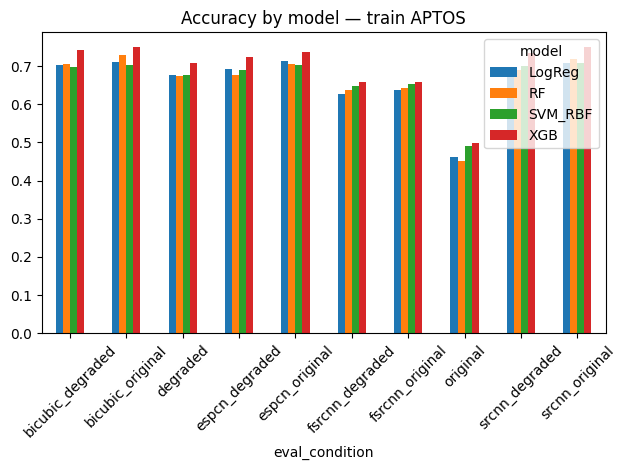

<Figure size 1200x600 with 0 Axes>

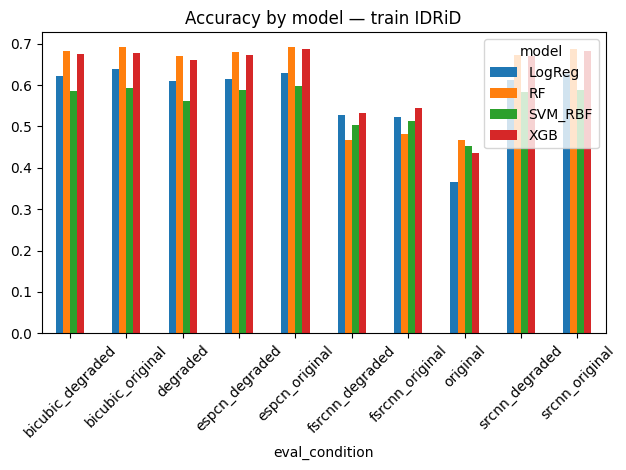

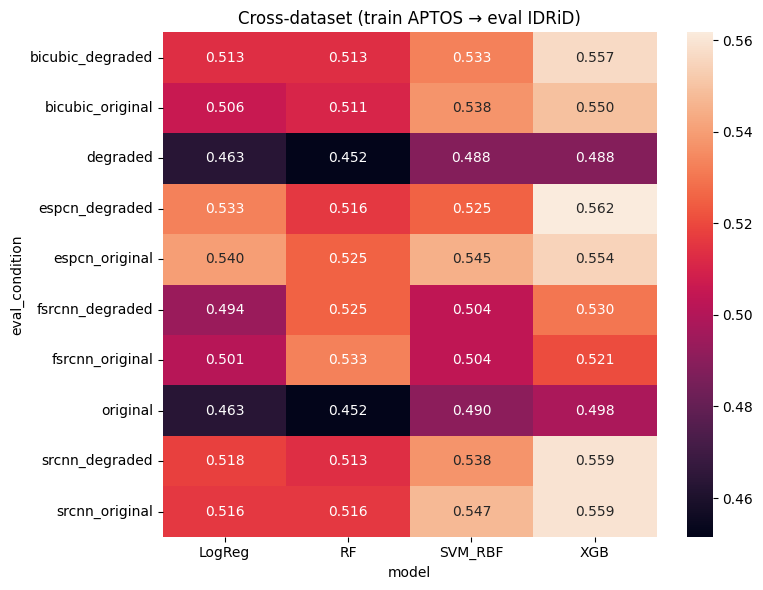

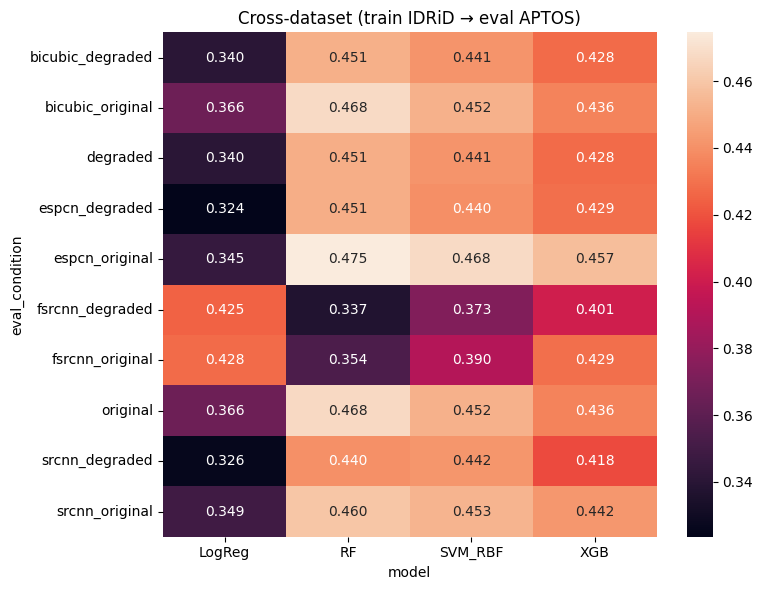

In [9]:
# ============================================================
# TRAIN & EVALUATE PIPELINE
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
backbone = build_feature_extractor(device)

aptos_conditions = get_aptos_conditions()
idrid_conditions = get_idrid_conditions()

results = []

def prepare_features(dataset, mapping):
    feats = {}
    print(f"\nPreparing features for {dataset}")
    for cname, cpath in mapping.items():
        print(f"  {cname}: {cpath}")
        if dataset == "APTOS":
            paths, labels = get_aptos_image_labels(cpath)
        else:
            paths, labels = get_idrid_image_labels(cpath)
        print(f"  images: {len(paths)}")
        X, y = extract_features(paths, labels, backbone, device, desc=f"{dataset}-{cname}")
        feats[cname] = (X, y)
    return feats

aptos_feats = prepare_features("APTOS", aptos_conditions)
idrid_feats = prepare_features("IDRiD", idrid_conditions)


def build_ml_models():
    m = {
        "LogReg": LogisticRegression(max_iter=1000,n_jobs=-1,solver="lbfgs",multi_class="multinomial"),
        "SVM_RBF": SVC(kernel="rbf",C=3,gamma="scale",probability=True),
        "RF": RandomForestClassifier(n_estimators=200,n_jobs=-1,random_state=42),
    }
    if HAS_XGB:
        m["XGB"] = XGBClassifier(
            n_estimators=400,max_depth=6,learning_rate=0.05,
            subsample=0.9,colsample_bytree=0.9,
            eval_metric="mlogloss",n_jobs=-1,random_state=42
        )
    return m


def run_experiment(train_name, train_feats, other_feats):
    X, y = train_feats["original"]
    print(f"\n=== TRAIN ON {train_name} ORIGINAL — samples {len(y)} ===")
    Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    for mname, model in build_ml_models().items():
        print(f"\nTraining {mname}")
        model.fit(Xtr, ytr)
        pred = model.predict(Xval)

        results.append({
            "train_dataset": train_name, "eval_dataset": train_name,
            "eval_condition": "original_val", "model": mname,
            "accuracy": accuracy_score(yval,pred),
            "balanced_accuracy": balanced_accuracy_score(yval,pred),
            "f1_weighted": f1_score(yval,pred,average="weighted"),
        })

        # same dataset, all conditions
        for cname, (Xc, yc) in train_feats.items():
            if cname == "original": continue
            pred = model.predict(Xc)
            results.append({
                "train_dataset": train_name, "eval_dataset": train_name,
                "eval_condition": cname, "model": mname,
                "accuracy": accuracy_score(yc,pred),
                "balanced_accuracy": balanced_accuracy_score(yc,pred),
                "f1_weighted": f1_score(yc,pred,average="weighted"),
            })

        # cross dataset
        other = "IDRiD" if train_name == "APTOS" else "APTOS"
        for cname, (Xc, yc) in other_feats.items():
            pred = model.predict(Xc)
            results.append({
                "train_dataset": train_name, "eval_dataset": other,
                "eval_condition": cname, "model": mname,
                "accuracy": accuracy_score(yc,pred),
                "balanced_accuracy": balanced_accuracy_score(yc,pred),
                "f1_weighted": f1_score(yc,pred,average="weighted"),
            })

run_experiment("APTOS", aptos_feats, idrid_feats)
run_experiment("IDRiD", idrid_feats, aptos_feats)


# ============================================================
# SAVE RESULTS
# ============================================================

df = pd.DataFrame(results)
df.to_csv("classical_ml_results_aptos_idrid_sr.csv", index=False)
print("\nSaved → classical_ml_results_aptos_idrid_sr.csv")
display(df)


# ============================================================
# PLOTS
# ============================================================

import seaborn as sns

for tds in ["APTOS","IDRiD"]:
    sub = df[(df.train_dataset == tds) & (df.eval_condition != "original_val")]
    pv = sub.pivot_table(index="eval_condition", columns="model", values="accuracy")
    plt.figure(figsize=(12,6))
    pv.plot(kind="bar")
    plt.title(f"Accuracy by model — train {tds}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for tds, eds in [("APTOS","IDRiD"),("IDRiD","APTOS")]:
    sub = df[(df.train_dataset == tds) & (df.eval_dataset == eds)]
    pv = sub.pivot_table(index="eval_condition", columns="model", values="accuracy")
    plt.figure(figsize=(8,6))
    sns.heatmap(pv, annot=True, fmt=".3f")
    plt.title(f"Cross-dataset (train {tds} → eval {eds})")
    plt.tight_layout()
    plt.show()


In [4]:
from pathlib import Path

PATHS = {
    "APTOS": {
        "original": Path("C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS/train_ready_512"),
        "degraded": Path("C:/Users/Jonathan Morel/Desktop/Honour/Data/APTOS/1. Degraded_x2_true"),

        "bicubic_original": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full/espcn_x2_original_true_aptos/bicubic_x1"),
        "bicubic_degraded": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full/espcn_x2_degraded_true_aptos/bicubic_x1"),

        "espcn_original": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full/espcn_x2_original_true_aptos/espcn_x1"),
        "espcn_degraded": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full/espcn_x2_degraded_true_aptos/espcn_x1"),

        "fsrcnn_original": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full/fsrcnn_x2_original_true_aptos/fsrcnn_x1"),
        "fsrcnn_degraded": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full/fsrcnn_x2_degraded_true_aptos/fsrcnn_x1"),

        "srcnn_original": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full/srcnn_x2_original_true_aptos/srcnn_x1"),
        "srcnn_degraded": Path("C:/Users/Jonathan Morel/Desktop/Honour/outputs/APTOS_SR_full/srcnn_x2_degraded_true_aptos/srcnn_x1"),
    }
}

VALID_EXT = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def count_images(folder: Path):
    if not folder.exists():
        return "FOLDER NOT FOUND"
    count = sum(1 for f in folder.rglob("*") if f.suffix.lower() in VALID_EXT)
    return count

print("===== CHECKING ALL APTOS SR FOLDERS =====")
for condition, path in PATHS["APTOS"].items():
    if condition == "original":
        continue
    print(f"{condition:18s} → {count_images(path)}")


===== CHECKING ALL APTOS SR FOLDERS =====
degraded           → 3662
bicubic_original   → 3662
bicubic_degraded   → 3662
espcn_original     → 3662
espcn_degraded     → 3662
fsrcnn_original    → 3662
fsrcnn_degraded    → 3662
srcnn_original     → 3662
srcnn_degraded     → 3662


# Classical Deep Learning Baselines

Loaded 413 IDRiD labels from CSV.
APTOS label map built: 3662
Using device: cuda

=== Building loaders for APTOS ===
APTOS original: 3662 images
APTOS original: 3662 images for eval loader
APTOS degraded: 3662 images for eval loader
APTOS bicubic_original: 3662 images for eval loader
APTOS bicubic_degraded: 3662 images for eval loader
APTOS espcn_original: 3662 images for eval loader
APTOS espcn_degraded: 3662 images for eval loader
APTOS fsrcnn_original: 3662 images for eval loader
APTOS fsrcnn_degraded: 3662 images for eval loader
APTOS srcnn_original: 3662 images for eval loader
APTOS srcnn_degraded: 3662 images for eval loader

=== Building loaders for IDRiD ===
IDRiD original: 516 images
IDRiD original: 516 images for eval loader
IDRiD degraded: 516 images for eval loader
IDRiD bicubic_original: 413 images for eval loader
IDRiD bicubic_degraded: 413 images for eval loader
IDRiD espcn_original: 413 images for eval loader
IDRiD espcn_degraded: 413 images for eval loader
IDRiD fsrcnn

Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.6819, acc 0.7491
Val   loss 0.5652, acc 0.7981
  → New best model saved.

Epoch 2/20 (ResNet18 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.4444, acc 0.8330
Val   loss 0.7011, acc 0.7462
  No improvement for 1 epoch(s).

Epoch 3/20 (ResNet18 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.3847, acc 0.8552
Val   loss 0.5236, acc 0.8117
  → New best model saved.

Epoch 4/20 (ResNet18 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.3341, acc 0.8764
Val   loss 0.5798, acc 0.7872
  No improvement for 1 epoch(s).

Epoch 5/20 (ResNet18 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.2653, acc 0.9013
Val   loss 0.5777, acc 0.7981
  No improvement for 2 epoch(s).

Epoch 6/20 (ResNet18 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.2210, acc 0.9222
Val   loss 0.6345, acc 0.7967
  No improvement for 3 epoch(s).

Epoch 7/20 (ResNet18 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.2038, acc 0.9269
Val   loss 0.6403, acc 0.8117
  No improvement for 4 epoch(s).

Epoch 8/20 (ResNet18 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.1657, acc 0.9461
Val   loss 0.6623, acc 0.8008
  No improvement for 5 epoch(s).
Early stopping triggered after 8 epochs.


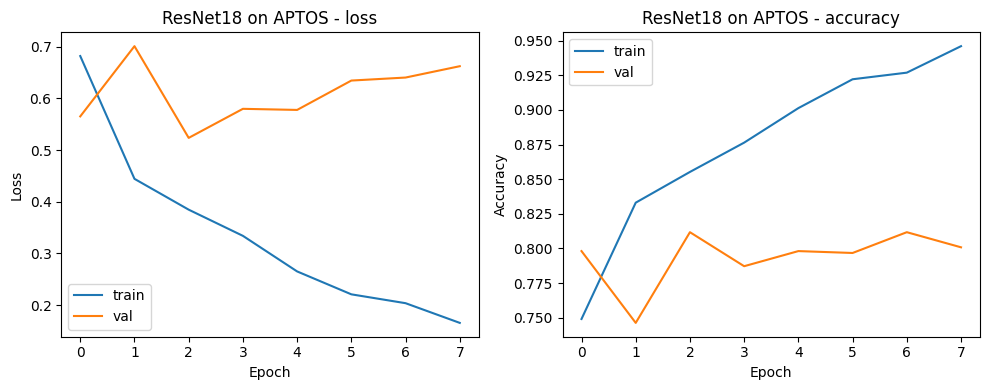


Evaluating best ResNet18 (APTOS) model on all conditions...


Eval:   0%|          | 0/23 [00:00<?, ?it/s]

[ResNet18] APTOS → APTOS:original_val | Acc=0.8008, F1w=0.8006


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] APTOS → APTOS:original_full | Acc=0.9377, F1w=0.9381


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] APTOS → APTOS:degraded | Acc=0.9345, F1w=0.9350


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] APTOS → APTOS:bicubic_original | Acc=0.9377, F1w=0.9381


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] APTOS → APTOS:bicubic_degraded | Acc=0.9345, F1w=0.9350


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] APTOS → APTOS:espcn_original | Acc=0.9244, F1w=0.9254


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] APTOS → APTOS:espcn_degraded | Acc=0.9189, F1w=0.9202


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] APTOS → APTOS:fsrcnn_original | Acc=0.7728, F1w=0.7706


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] APTOS → APTOS:fsrcnn_degraded | Acc=0.7540, F1w=0.7516


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] APTOS → APTOS:srcnn_original | Acc=0.9334, F1w=0.9337


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] APTOS → APTOS:srcnn_degraded | Acc=0.9287, F1w=0.9292

Cross-dataset evaluation: ResNet18 train APTOS → eval IDRiD


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

[ResNet18] APTOS → IDRiD:original | Acc=0.4457, F1w=0.4624


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

[ResNet18] APTOS → IDRiD:degraded | Acc=0.4477, F1w=0.4616


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet18] APTOS → IDRiD:bicubic_original | Acc=0.4988, F1w=0.5181


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet18] APTOS → IDRiD:bicubic_degraded | Acc=0.5012, F1w=0.5222


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet18] APTOS → IDRiD:espcn_original | Acc=0.4988, F1w=0.5157


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet18] APTOS → IDRiD:espcn_degraded | Acc=0.4939, F1w=0.5115


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet18] APTOS → IDRiD:fsrcnn_original | Acc=0.4262, F1w=0.4460


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet18] APTOS → IDRiD:fsrcnn_degraded | Acc=0.4237, F1w=0.4459


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet18] APTOS → IDRiD:srcnn_original | Acc=0.4915, F1w=0.5114


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet18] APTOS → IDRiD:srcnn_degraded | Acc=0.4988, F1w=0.5191

Training ResNet50 on APTOS ORIGINAL

Epoch 1/20 (ResNet50 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.6578, acc 0.7511
Val   loss 0.5645, acc 0.7885
  → New best model saved.

Epoch 2/20 (ResNet50 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.4831, acc 0.8231
Val   loss 0.5396, acc 0.7954
  → New best model saved.

Epoch 3/20 (ResNet50 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.3929, acc 0.8549
Val   loss 0.5216, acc 0.8063
  → New best model saved.

Epoch 4/20 (ResNet50 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.3542, acc 0.8689
Val   loss 0.5204, acc 0.8022
  No improvement for 1 epoch(s).

Epoch 5/20 (ResNet50 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.2798, acc 0.8993
Val   loss 0.5216, acc 0.8063
  No improvement for 2 epoch(s).

Epoch 6/20 (ResNet50 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.2478, acc 0.9088
Val   loss 0.5707, acc 0.8172
  → New best model saved.

Epoch 7/20 (ResNet50 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.2232, acc 0.9126
Val   loss 0.5938, acc 0.8104
  No improvement for 1 epoch(s).

Epoch 8/20 (ResNet50 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.1658, acc 0.9406
Val   loss 0.7220, acc 0.8131
  No improvement for 2 epoch(s).

Epoch 9/20 (ResNet50 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.1829, acc 0.9365
Val   loss 0.5635, acc 0.8158
  No improvement for 3 epoch(s).

Epoch 10/20 (ResNet50 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.1535, acc 0.9454
Val   loss 0.6462, acc 0.8022
  No improvement for 4 epoch(s).

Epoch 11/20 (ResNet50 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.1284, acc 0.9508
Val   loss 0.7160, acc 0.8008
  No improvement for 5 epoch(s).
Early stopping triggered after 11 epochs.


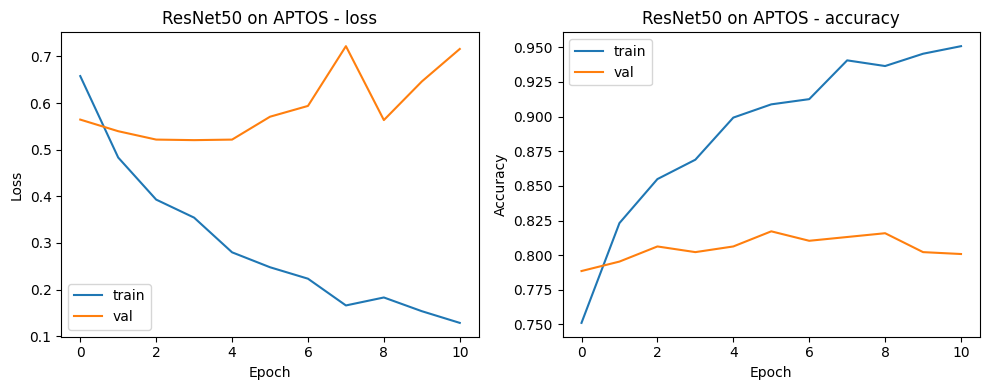


Evaluating best ResNet50 (APTOS) model on all conditions...


Eval:   0%|          | 0/23 [00:00<?, ?it/s]

[ResNet50] APTOS → APTOS:original_val | Acc=0.8008, F1w=0.7994


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] APTOS → APTOS:original_full | Acc=0.9383, F1w=0.9388


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] APTOS → APTOS:degraded | Acc=0.9383, F1w=0.9384


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] APTOS → APTOS:bicubic_original | Acc=0.9383, F1w=0.9388


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] APTOS → APTOS:bicubic_degraded | Acc=0.9383, F1w=0.9384


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] APTOS → APTOS:espcn_original | Acc=0.9353, F1w=0.9357


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] APTOS → APTOS:espcn_degraded | Acc=0.9345, F1w=0.9347


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] APTOS → APTOS:fsrcnn_original | Acc=0.8247, F1w=0.8246


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] APTOS → APTOS:fsrcnn_degraded | Acc=0.8088, F1w=0.8092


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] APTOS → APTOS:srcnn_original | Acc=0.9369, F1w=0.9373


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] APTOS → APTOS:srcnn_degraded | Acc=0.9358, F1w=0.9359

Cross-dataset evaluation: ResNet50 train APTOS → eval IDRiD


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

[ResNet50] APTOS → IDRiD:original | Acc=0.3605, F1w=0.3825


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

[ResNet50] APTOS → IDRiD:degraded | Acc=0.3527, F1w=0.3713


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet50] APTOS → IDRiD:bicubic_original | Acc=0.3850, F1w=0.4034


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet50] APTOS → IDRiD:bicubic_degraded | Acc=0.3826, F1w=0.3945


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet50] APTOS → IDRiD:espcn_original | Acc=0.3826, F1w=0.3989


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet50] APTOS → IDRiD:espcn_degraded | Acc=0.3753, F1w=0.3855


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet50] APTOS → IDRiD:fsrcnn_original | Acc=0.3341, F1w=0.3298


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet50] APTOS → IDRiD:fsrcnn_degraded | Acc=0.3317, F1w=0.3236


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet50] APTOS → IDRiD:srcnn_original | Acc=0.3874, F1w=0.4071


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet50] APTOS → IDRiD:srcnn_degraded | Acc=0.3777, F1w=0.3936

Training EffNetB0 on APTOS ORIGINAL

Epoch 1/20 (EffNetB0 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.8809, acc 0.6907
Val   loss 0.6187, acc 0.7585
  → New best model saved.

Epoch 2/20 (EffNetB0 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.5460, acc 0.7941
Val   loss 0.5233, acc 0.7926
  → New best model saved.

Epoch 3/20 (EffNetB0 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.4633, acc 0.8317
Val   loss 0.4820, acc 0.8158
  → New best model saved.

Epoch 4/20 (EffNetB0 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.4002, acc 0.8549
Val   loss 0.4715, acc 0.8240
  → New best model saved.

Epoch 5/20 (EffNetB0 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.3440, acc 0.8689
Val   loss 0.4735, acc 0.8349
  → New best model saved.

Epoch 6/20 (EffNetB0 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.3021, acc 0.8925
Val   loss 0.5186, acc 0.8267
  No improvement for 1 epoch(s).

Epoch 7/20 (EffNetB0 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.2598, acc 0.9027
Val   loss 0.5223, acc 0.8295
  No improvement for 2 epoch(s).

Epoch 8/20 (EffNetB0 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.2250, acc 0.9184
Val   loss 0.5498, acc 0.8240
  No improvement for 3 epoch(s).

Epoch 9/20 (EffNetB0 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.1875, acc 0.9348
Val   loss 0.5862, acc 0.8240
  No improvement for 4 epoch(s).

Epoch 10/20 (EffNetB0 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.1591, acc 0.9488
Val   loss 0.6428, acc 0.8226
  No improvement for 5 epoch(s).
Early stopping triggered after 10 epochs.


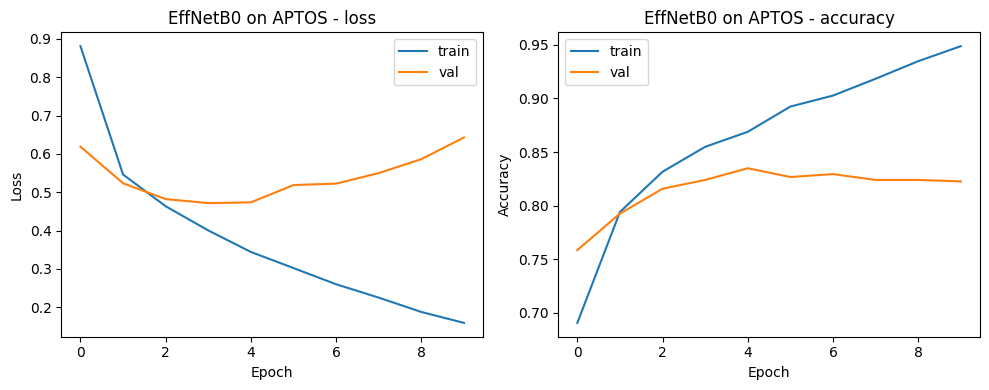


Evaluating best EffNetB0 (APTOS) model on all conditions...


Eval:   0%|          | 0/23 [00:00<?, ?it/s]

[EffNetB0] APTOS → APTOS:original_val | Acc=0.8226, F1w=0.8198


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] APTOS → APTOS:original_full | Acc=0.9517, F1w=0.9516


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] APTOS → APTOS:degraded | Acc=0.9429, F1w=0.9427


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] APTOS → APTOS:bicubic_original | Acc=0.9517, F1w=0.9516


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] APTOS → APTOS:bicubic_degraded | Acc=0.9429, F1w=0.9427


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] APTOS → APTOS:espcn_original | Acc=0.9397, F1w=0.9397


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] APTOS → APTOS:espcn_degraded | Acc=0.9260, F1w=0.9263


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] APTOS → APTOS:fsrcnn_original | Acc=0.7316, F1w=0.7289


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] APTOS → APTOS:fsrcnn_degraded | Acc=0.6972, F1w=0.6874


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] APTOS → APTOS:srcnn_original | Acc=0.9437, F1w=0.9440


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] APTOS → APTOS:srcnn_degraded | Acc=0.9388, F1w=0.9388

Cross-dataset evaluation: EffNetB0 train APTOS → eval IDRiD


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

[EffNetB0] APTOS → IDRiD:original | Acc=0.4167, F1w=0.4391


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

[EffNetB0] APTOS → IDRiD:degraded | Acc=0.4205, F1w=0.4393


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[EffNetB0] APTOS → IDRiD:bicubic_original | Acc=0.4600, F1w=0.4817


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[EffNetB0] APTOS → IDRiD:bicubic_degraded | Acc=0.4722, F1w=0.4907


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[EffNetB0] APTOS → IDRiD:espcn_original | Acc=0.4600, F1w=0.4814


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[EffNetB0] APTOS → IDRiD:espcn_degraded | Acc=0.4673, F1w=0.4906


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[EffNetB0] APTOS → IDRiD:fsrcnn_original | Acc=0.4262, F1w=0.4267


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[EffNetB0] APTOS → IDRiD:fsrcnn_degraded | Acc=0.4334, F1w=0.4336


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[EffNetB0] APTOS → IDRiD:srcnn_original | Acc=0.4600, F1w=0.4831


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[EffNetB0] APTOS → IDRiD:srcnn_degraded | Acc=0.4600, F1w=0.4822

Training ViT_B16 on APTOS ORIGINAL

Epoch 1/20 (ViT_B16 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.7911, acc 0.7166
Val   loss 0.7219, acc 0.7503
  → New best model saved.

Epoch 2/20 (ViT_B16 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.6174, acc 0.7699
Val   loss 0.6183, acc 0.7831
  → New best model saved.

Epoch 3/20 (ViT_B16 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.5343, acc 0.8085
Val   loss 0.5990, acc 0.7681
  No improvement for 1 epoch(s).

Epoch 4/20 (ViT_B16 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.5168, acc 0.8006
Val   loss 0.6563, acc 0.7885
  → New best model saved.

Epoch 5/20 (ViT_B16 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.4689, acc 0.8269
Val   loss 0.6395, acc 0.7804
  No improvement for 1 epoch(s).

Epoch 6/20 (ViT_B16 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.4395, acc 0.8412
Val   loss 0.5602, acc 0.7954
  → New best model saved.

Epoch 7/20 (ViT_B16 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.3888, acc 0.8563
Val   loss 0.5302, acc 0.8090
  → New best model saved.

Epoch 8/20 (ViT_B16 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.3628, acc 0.8662
Val   loss 0.5930, acc 0.7940
  No improvement for 1 epoch(s).

Epoch 9/20 (ViT_B16 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.3720, acc 0.8628
Val   loss 0.6320, acc 0.7749
  No improvement for 2 epoch(s).

Epoch 10/20 (ViT_B16 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.3181, acc 0.8836
Val   loss 0.6108, acc 0.7913
  No improvement for 3 epoch(s).

Epoch 11/20 (ViT_B16 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.3125, acc 0.8870
Val   loss 0.5795, acc 0.8090
  No improvement for 4 epoch(s).

Epoch 12/20 (ViT_B16 | APTOS)


Train:   0%|          | 0/92 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Train loss 0.2815, acc 0.8983
Val   loss 0.6419, acc 0.7995
  No improvement for 5 epoch(s).
Early stopping triggered after 12 epochs.


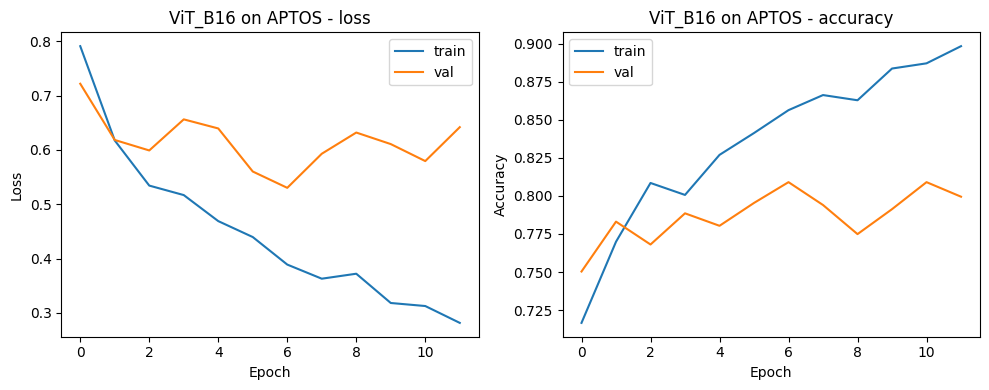


Evaluating best ViT_B16 (APTOS) model on all conditions...


Eval:   0%|          | 0/23 [00:00<?, ?it/s]

[ViT_B16] APTOS → APTOS:original_val | Acc=0.7995, F1w=0.7891


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] APTOS → APTOS:original_full | Acc=0.8960, F1w=0.8931


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] APTOS → APTOS:degraded | Acc=0.8965, F1w=0.8939


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] APTOS → APTOS:bicubic_original | Acc=0.8960, F1w=0.8931


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] APTOS → APTOS:bicubic_degraded | Acc=0.8965, F1w=0.8939


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] APTOS → APTOS:espcn_original | Acc=0.8976, F1w=0.8955


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] APTOS → APTOS:espcn_degraded | Acc=0.8973, F1w=0.8951


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] APTOS → APTOS:fsrcnn_original | Acc=0.7693, F1w=0.7563


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] APTOS → APTOS:fsrcnn_degraded | Acc=0.7690, F1w=0.7557


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] APTOS → APTOS:srcnn_original | Acc=0.8965, F1w=0.8937


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] APTOS → APTOS:srcnn_degraded | Acc=0.8976, F1w=0.8950

Cross-dataset evaluation: ViT_B16 train APTOS → eval IDRiD


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

[ViT_B16] APTOS → IDRiD:original | Acc=0.3760, F1w=0.3572


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

[ViT_B16] APTOS → IDRiD:degraded | Acc=0.3740, F1w=0.3560


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ViT_B16] APTOS → IDRiD:bicubic_original | Acc=0.4068, F1w=0.3855


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ViT_B16] APTOS → IDRiD:bicubic_degraded | Acc=0.4140, F1w=0.3901


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ViT_B16] APTOS → IDRiD:espcn_original | Acc=0.4068, F1w=0.3827


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ViT_B16] APTOS → IDRiD:espcn_degraded | Acc=0.4019, F1w=0.3756


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ViT_B16] APTOS → IDRiD:fsrcnn_original | Acc=0.3220, F1w=0.2737


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ViT_B16] APTOS → IDRiD:fsrcnn_degraded | Acc=0.3317, F1w=0.2840


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ViT_B16] APTOS → IDRiD:srcnn_original | Acc=0.4165, F1w=0.3908


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ViT_B16] APTOS → IDRiD:srcnn_degraded | Acc=0.4116, F1w=0.3862

Training ResNet18 on IDRiD ORIGINAL

Epoch 1/20 (ResNet18 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.3059, acc 0.4782
Val   loss 1.4172, acc 0.4808
  → New best model saved.

Epoch 2/20 (ResNet18 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.9243, acc 0.6117
Val   loss 1.1479, acc 0.5192
  → New best model saved.

Epoch 3/20 (ResNet18 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.7740, acc 0.7184
Val   loss 1.2083, acc 0.5000
  No improvement for 1 epoch(s).

Epoch 4/20 (ResNet18 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.6028, acc 0.7937
Val   loss 1.1811, acc 0.5865
  → New best model saved.

Epoch 5/20 (ResNet18 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.4483, acc 0.8689
Val   loss 1.3314, acc 0.5192
  No improvement for 1 epoch(s).

Epoch 6/20 (ResNet18 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.3280, acc 0.9175
Val   loss 1.3156, acc 0.4904
  No improvement for 2 epoch(s).

Epoch 7/20 (ResNet18 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.2621, acc 0.9369
Val   loss 1.4489, acc 0.5481
  No improvement for 3 epoch(s).

Epoch 8/20 (ResNet18 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.2473, acc 0.9248
Val   loss 1.3883, acc 0.5288
  No improvement for 4 epoch(s).

Epoch 9/20 (ResNet18 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.2097, acc 0.9466
Val   loss 1.3835, acc 0.4904
  No improvement for 5 epoch(s).
Early stopping triggered after 9 epochs.


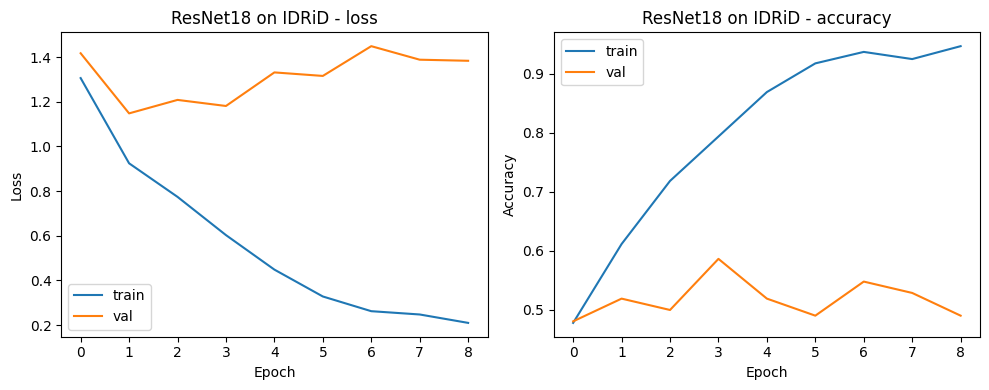


Evaluating best ResNet18 (IDRiD) model on all conditions...


Eval:   0%|          | 0/4 [00:00<?, ?it/s]

[ResNet18] IDRiD → IDRiD:original_val | Acc=0.4904, F1w=0.4845


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

[ResNet18] IDRiD → IDRiD:original_full | Acc=0.8798, F1w=0.8796


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

[ResNet18] IDRiD → IDRiD:degraded | Acc=0.8740, F1w=0.8736


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet18] IDRiD → IDRiD:bicubic_original | Acc=0.8983, F1w=0.8987


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet18] IDRiD → IDRiD:bicubic_degraded | Acc=0.8959, F1w=0.8963


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet18] IDRiD → IDRiD:espcn_original | Acc=0.8959, F1w=0.8963


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet18] IDRiD → IDRiD:espcn_degraded | Acc=0.8959, F1w=0.8962


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet18] IDRiD → IDRiD:fsrcnn_original | Acc=0.7506, F1w=0.7373


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet18] IDRiD → IDRiD:fsrcnn_degraded | Acc=0.7409, F1w=0.7280


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet18] IDRiD → IDRiD:srcnn_original | Acc=0.8959, F1w=0.8963


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet18] IDRiD → IDRiD:srcnn_degraded | Acc=0.8959, F1w=0.8962

Cross-dataset evaluation: ResNet18 train IDRiD → eval APTOS


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] IDRiD → APTOS:original | Acc=0.3514, F1w=0.3823


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] IDRiD → APTOS:degraded | Acc=0.3351, F1w=0.3682


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] IDRiD → APTOS:bicubic_original | Acc=0.3514, F1w=0.3823


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] IDRiD → APTOS:bicubic_degraded | Acc=0.3351, F1w=0.3682


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] IDRiD → APTOS:espcn_original | Acc=0.3378, F1w=0.3701


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] IDRiD → APTOS:espcn_degraded | Acc=0.3094, F1w=0.3412


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] IDRiD → APTOS:fsrcnn_original | Acc=0.3591, F1w=0.3616


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] IDRiD → APTOS:fsrcnn_degraded | Acc=0.3487, F1w=0.3587


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] IDRiD → APTOS:srcnn_original | Acc=0.3413, F1w=0.3690


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet18] IDRiD → APTOS:srcnn_degraded | Acc=0.3269, F1w=0.3557

Training ResNet50 on IDRiD ORIGINAL

Epoch 1/20 (ResNet50 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.3013, acc 0.4709
Val   loss 1.2494, acc 0.5096
  → New best model saved.

Epoch 2/20 (ResNet50 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.9289, acc 0.6238
Val   loss 1.2283, acc 0.5673
  → New best model saved.

Epoch 3/20 (ResNet50 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.7425, acc 0.7306
Val   loss 1.3548, acc 0.6058
  → New best model saved.

Epoch 4/20 (ResNet50 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.5718, acc 0.7888
Val   loss 1.4077, acc 0.5769
  No improvement for 1 epoch(s).

Epoch 5/20 (ResNet50 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.4298, acc 0.8689
Val   loss 1.5578, acc 0.5385
  No improvement for 2 epoch(s).

Epoch 6/20 (ResNet50 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.3725, acc 0.8908
Val   loss 1.7755, acc 0.5385
  No improvement for 3 epoch(s).

Epoch 7/20 (ResNet50 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.3151, acc 0.8883
Val   loss 1.7874, acc 0.5481
  No improvement for 4 epoch(s).

Epoch 8/20 (ResNet50 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.2148, acc 0.9369
Val   loss 2.1251, acc 0.5481
  No improvement for 5 epoch(s).
Early stopping triggered after 8 epochs.


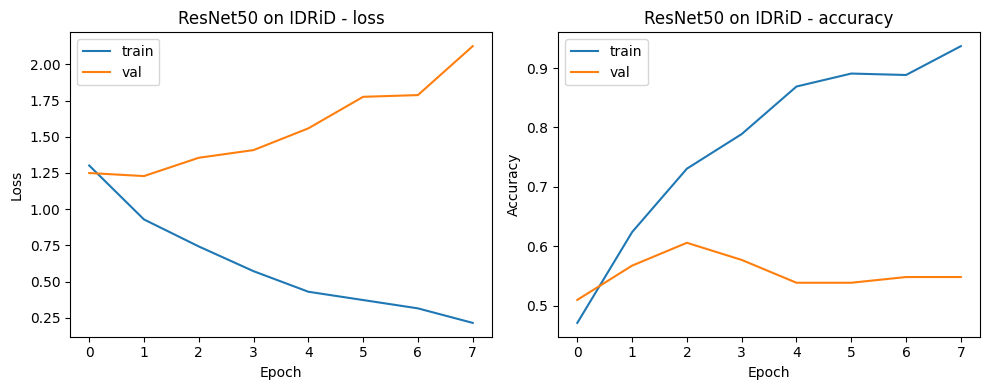


Evaluating best ResNet50 (IDRiD) model on all conditions...


Eval:   0%|          | 0/4 [00:00<?, ?it/s]

[ResNet50] IDRiD → IDRiD:original_val | Acc=0.5481, F1w=0.5092


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

[ResNet50] IDRiD → IDRiD:original_full | Acc=0.8488, F1w=0.8438


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

[ResNet50] IDRiD → IDRiD:degraded | Acc=0.8508, F1w=0.8463


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet50] IDRiD → IDRiD:bicubic_original | Acc=0.8814, F1w=0.8786


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet50] IDRiD → IDRiD:bicubic_degraded | Acc=0.8910, F1w=0.8890


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet50] IDRiD → IDRiD:espcn_original | Acc=0.8862, F1w=0.8837


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet50] IDRiD → IDRiD:espcn_degraded | Acc=0.8910, F1w=0.8887


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet50] IDRiD → IDRiD:fsrcnn_original | Acc=0.6877, F1w=0.6417


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet50] IDRiD → IDRiD:fsrcnn_degraded | Acc=0.6877, F1w=0.6422


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet50] IDRiD → IDRiD:srcnn_original | Acc=0.8910, F1w=0.8895


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ResNet50] IDRiD → IDRiD:srcnn_degraded | Acc=0.8814, F1w=0.8788

Cross-dataset evaluation: ResNet50 train IDRiD → eval APTOS


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] IDRiD → APTOS:original | Acc=0.4533, F1w=0.4409


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] IDRiD → APTOS:degraded | Acc=0.4448, F1w=0.4350


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] IDRiD → APTOS:bicubic_original | Acc=0.4533, F1w=0.4409


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] IDRiD → APTOS:bicubic_degraded | Acc=0.4448, F1w=0.4350


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] IDRiD → APTOS:espcn_original | Acc=0.4637, F1w=0.4565


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] IDRiD → APTOS:espcn_degraded | Acc=0.4517, F1w=0.4464


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] IDRiD → APTOS:fsrcnn_original | Acc=0.4558, F1w=0.4159


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] IDRiD → APTOS:fsrcnn_degraded | Acc=0.4432, F1w=0.4059


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] IDRiD → APTOS:srcnn_original | Acc=0.4478, F1w=0.4377


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ResNet50] IDRiD → APTOS:srcnn_degraded | Acc=0.4410, F1w=0.4320

Training EffNetB0 on IDRiD ORIGINAL

Epoch 1/20 (EffNetB0 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.5442, acc 0.3034
Val   loss 1.4500, acc 0.4808
  → New best model saved.

Epoch 2/20 (EffNetB0 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.3059, acc 0.5825
Val   loss 1.2789, acc 0.4712
  No improvement for 1 epoch(s).

Epoch 3/20 (EffNetB0 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.1688, acc 0.6044
Val   loss 1.2236, acc 0.5288
  → New best model saved.

Epoch 4/20 (EffNetB0 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.0309, acc 0.6311
Val   loss 1.1758, acc 0.5673
  → New best model saved.

Epoch 5/20 (EffNetB0 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.9559, acc 0.6408
Val   loss 1.1496, acc 0.5481
  No improvement for 1 epoch(s).

Epoch 6/20 (EffNetB0 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.8782, acc 0.6820
Val   loss 1.1286, acc 0.5577
  No improvement for 2 epoch(s).

Epoch 7/20 (EffNetB0 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.7767, acc 0.7209
Val   loss 1.1215, acc 0.5385
  No improvement for 3 epoch(s).

Epoch 8/20 (EffNetB0 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.6716, acc 0.7767
Val   loss 1.1553, acc 0.5481
  No improvement for 4 epoch(s).

Epoch 9/20 (EffNetB0 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.6194, acc 0.7985
Val   loss 1.1490, acc 0.5288
  No improvement for 5 epoch(s).
Early stopping triggered after 9 epochs.


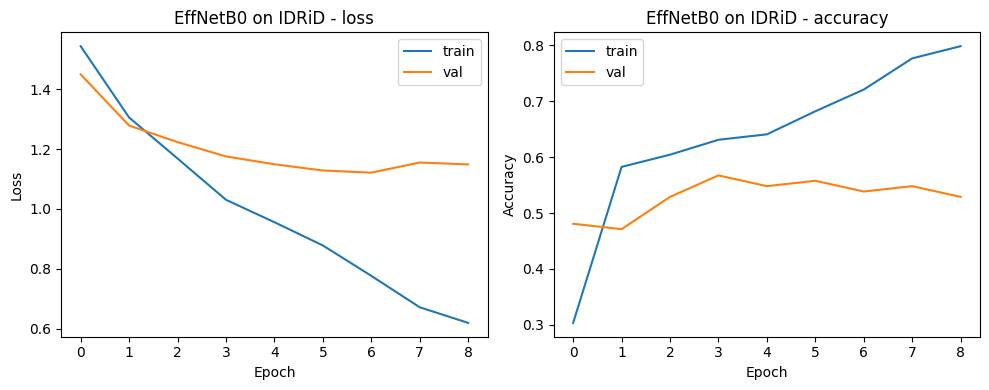


Evaluating best EffNetB0 (IDRiD) model on all conditions...


Eval:   0%|          | 0/4 [00:00<?, ?it/s]

[EffNetB0] IDRiD → IDRiD:original_val | Acc=0.5288, F1w=0.4959


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

[EffNetB0] IDRiD → IDRiD:original_full | Acc=0.8043, F1w=0.8002


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

[EffNetB0] IDRiD → IDRiD:degraded | Acc=0.7946, F1w=0.7903


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[EffNetB0] IDRiD → IDRiD:bicubic_original | Acc=0.8523, F1w=0.8504


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[EffNetB0] IDRiD → IDRiD:bicubic_degraded | Acc=0.8450, F1w=0.8438


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[EffNetB0] IDRiD → IDRiD:espcn_original | Acc=0.8499, F1w=0.8479


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[EffNetB0] IDRiD → IDRiD:espcn_degraded | Acc=0.8426, F1w=0.8415


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[EffNetB0] IDRiD → IDRiD:fsrcnn_original | Acc=0.7046, F1w=0.6897


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[EffNetB0] IDRiD → IDRiD:fsrcnn_degraded | Acc=0.7119, F1w=0.6961


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[EffNetB0] IDRiD → IDRiD:srcnn_original | Acc=0.8499, F1w=0.8485


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[EffNetB0] IDRiD → IDRiD:srcnn_degraded | Acc=0.8475, F1w=0.8457

Cross-dataset evaluation: EffNetB0 train IDRiD → eval APTOS


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] IDRiD → APTOS:original | Acc=0.6229, F1w=0.6110


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] IDRiD → APTOS:degraded | Acc=0.5724, F1w=0.5700


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] IDRiD → APTOS:bicubic_original | Acc=0.6229, F1w=0.6110


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] IDRiD → APTOS:bicubic_degraded | Acc=0.5724, F1w=0.5700


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] IDRiD → APTOS:espcn_original | Acc=0.5885, F1w=0.5877


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] IDRiD → APTOS:espcn_degraded | Acc=0.5147, F1w=0.5266


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] IDRiD → APTOS:fsrcnn_original | Acc=0.6660, F1w=0.6297


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] IDRiD → APTOS:fsrcnn_degraded | Acc=0.6240, F1w=0.6014


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] IDRiD → APTOS:srcnn_original | Acc=0.6171, F1w=0.6056


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[EffNetB0] IDRiD → APTOS:srcnn_degraded | Acc=0.5806, F1w=0.5787

Training ViT_B16 on IDRiD ORIGINAL

Epoch 1/20 (ViT_B16 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.6140, acc 0.3228
Val   loss 1.4434, acc 0.4904
  → New best model saved.

Epoch 2/20 (ViT_B16 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.4845, acc 0.3277
Val   loss 1.4180, acc 0.3942
  No improvement for 1 epoch(s).

Epoch 3/20 (ViT_B16 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.4474, acc 0.3883
Val   loss 1.4200, acc 0.3846
  No improvement for 2 epoch(s).

Epoch 4/20 (ViT_B16 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.4182, acc 0.4053
Val   loss 1.4152, acc 0.3462
  No improvement for 3 epoch(s).

Epoch 5/20 (ViT_B16 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.3980, acc 0.4005
Val   loss 1.2862, acc 0.5096
  → New best model saved.

Epoch 6/20 (ViT_B16 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.3673, acc 0.3762
Val   loss 1.2842, acc 0.4808
  No improvement for 1 epoch(s).

Epoch 7/20 (ViT_B16 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.3033, acc 0.4539
Val   loss 1.2762, acc 0.4231
  No improvement for 2 epoch(s).

Epoch 8/20 (ViT_B16 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.3229, acc 0.4296
Val   loss 1.2252, acc 0.4712
  No improvement for 3 epoch(s).

Epoch 9/20 (ViT_B16 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.2151, acc 0.4684
Val   loss 1.3056, acc 0.4615
  No improvement for 4 epoch(s).

Epoch 10/20 (ViT_B16 | IDRiD)


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Eval:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.2489, acc 0.4879
Val   loss 1.2553, acc 0.5000
  No improvement for 5 epoch(s).
Early stopping triggered after 10 epochs.


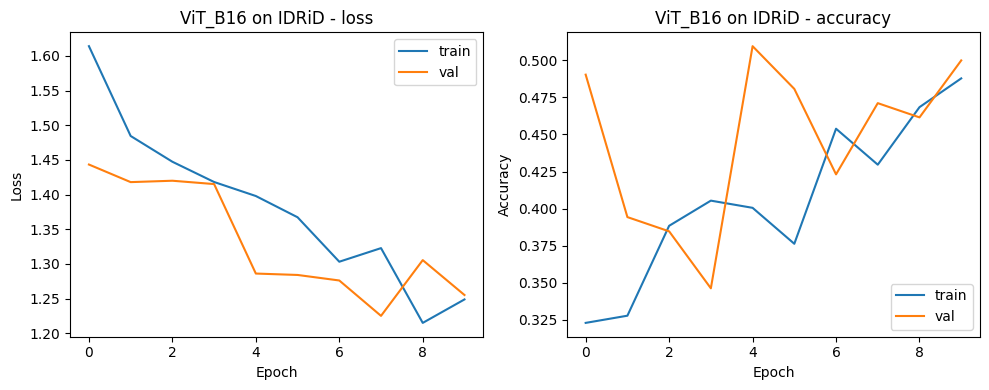


Evaluating best ViT_B16 (IDRiD) model on all conditions...


Eval:   0%|          | 0/4 [00:00<?, ?it/s]

[ViT_B16] IDRiD → IDRiD:original_val | Acc=0.5000, F1w=0.3903


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

[ViT_B16] IDRiD → IDRiD:original_full | Acc=0.4845, F1w=0.3768


Eval:   0%|          | 0/17 [00:00<?, ?it/s]

[ViT_B16] IDRiD → IDRiD:degraded | Acc=0.4884, F1w=0.3800


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ViT_B16] IDRiD → IDRiD:bicubic_original | Acc=0.5157, F1w=0.4218


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ViT_B16] IDRiD → IDRiD:bicubic_degraded | Acc=0.5182, F1w=0.4238


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ViT_B16] IDRiD → IDRiD:espcn_original | Acc=0.5206, F1w=0.4259


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ViT_B16] IDRiD → IDRiD:espcn_degraded | Acc=0.5206, F1w=0.4259


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ViT_B16] IDRiD → IDRiD:fsrcnn_original | Acc=0.4794, F1w=0.3896


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ViT_B16] IDRiD → IDRiD:fsrcnn_degraded | Acc=0.4794, F1w=0.3891


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ViT_B16] IDRiD → IDRiD:srcnn_original | Acc=0.5182, F1w=0.4238


Eval:   0%|          | 0/13 [00:00<?, ?it/s]

[ViT_B16] IDRiD → IDRiD:srcnn_degraded | Acc=0.5206, F1w=0.4259

Cross-dataset evaluation: ViT_B16 train IDRiD → eval APTOS


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] IDRiD → APTOS:original | Acc=0.4001, F1w=0.3489


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] IDRiD → APTOS:degraded | Acc=0.3960, F1w=0.3442


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] IDRiD → APTOS:bicubic_original | Acc=0.4001, F1w=0.3489


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] IDRiD → APTOS:bicubic_degraded | Acc=0.3960, F1w=0.3442


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] IDRiD → APTOS:espcn_original | Acc=0.3973, F1w=0.3462


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] IDRiD → APTOS:espcn_degraded | Acc=0.3921, F1w=0.3398


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] IDRiD → APTOS:fsrcnn_original | Acc=0.3927, F1w=0.3416


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] IDRiD → APTOS:fsrcnn_degraded | Acc=0.3856, F1w=0.3328


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] IDRiD → APTOS:srcnn_original | Acc=0.3946, F1w=0.3428


Eval:   0%|          | 0/115 [00:00<?, ?it/s]

[ViT_B16] IDRiD → APTOS:srcnn_degraded | Acc=0.3930, F1w=0.3403

Saved DL results → dl_resnet_effnet_vit_results_aptos_idrid_sr_20ep.csv
Total rows: 168


,model,train_dataset,eval_dataset,eval_condition,accuracy,balanced_accuracy,f1_weighted
0,EffNetB0,APTOS,APTOS,bicubic_degraded,0.942927,0.888022,0.942734
1,EffNetB0,APTOS,APTOS,bicubic_original,0.951666,0.905047,0.951572
2,EffNetB0,APTOS,APTOS,degraded,0.942927,0.888022,0.942734
3,EffNetB0,APTOS,APTOS,espcn_degraded,0.925997,0.867423,0.926342
4,EffNetB0,APTOS,APTOS,espcn_original,0.939650,0.888170,0.939706
...,...,...,...,...,...,...,...
163,ViT_B16,IDRiD,IDRiD,fsrcnn_original,0.479419,0.292801,0.389572
164,ViT_B16,IDRiD,IDRiD,original_full,0.484496,0.310153,0.376764
165,ViT_B16,IDRiD,IDRiD,original_val,0.500000,0.321121,0.390309
166,ViT_B16,IDRiD,IDRiD,srcnn_degraded,0.520581,0.318218,0.425903


In [ ]:
# ============================================================
# Deep Learning baselines on APTOS + IDRiD with SR variants
# Train DL models on ORIGINAL only, evaluate on all conditions
# ============================================================

import os
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd

from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

import matplotlib.pyplot as plt

try:
    from IPython.display import display
except ImportError:
    display = print


# ============================================================
# PATH CONFIGURATION (matching classical ML script)
# ============================================================

# APTOS
APTOS_ORIG = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train_ready_512")
APTOS_DEG  = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\1. Degraded_x2_true")
APTOS_SR_ROOT = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full")

# IDRiD
IDRID_ORIG = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Original Images")
IDRID_DEG  = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Degraded_x2")
IDRID_SR_ROOT = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\outputs\sr_images_v2")

IDRID_LABEL_CSV = Path(
    r"C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\2. Groundtruths\a. IDRiD_Disease Grading_Training Labels.csv"
)

VALID_EXT = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}


# ============================================================
# CONDITION → PATH MAPPING (APTOS / IDRiD)
# ============================================================

def get_aptos_conditions():
    root = APTOS_SR_ROOT
    return {
        "original":          APTOS_ORIG,
        "degraded":          APTOS_DEG,
        "bicubic_original":  root / "espcn_x2_original_true_aptos" / "bicubic_x1",
        "bicubic_degraded":  root / "espcn_x2_degraded_true_aptos" / "bicubic_x1",
        "espcn_original":    root / "espcn_x2_original_true_aptos" / "espcn_x1",
        "espcn_degraded":    root / "espcn_x2_degraded_true_aptos" / "espcn_x1",
        "fsrcnn_original":   root / "fsrcnn_x2_original_true_aptos" / "fsrcnn_x1",
        "fsrcnn_degraded":   root / "fsrcnn_x2_degraded_true_aptos" / "fsrcnn_x1",
        "srcnn_original":    root / "srcnn_x2_original_true_aptos" / "srcnn_x1",
        "srcnn_degraded":    root / "srcnn_x2_degraded_true_aptos" / "srcnn_x1",
    }


def get_idrid_conditions():
    root = IDRID_SR_ROOT
    return {
        "original":          IDRID_ORIG,
        "degraded":          IDRID_DEG,
        "bicubic_original":  root / "espcn_x2_original" / "bicubic_x1",
        "bicubic_degraded":  root / "espcn_x2_degraded" / "bicubic_x1",
        "espcn_original":    root / "espcn_x2_original" / "espcn_x1",
        "espcn_degraded":    root / "espcn_x2_degraded" / "espcn_x1",
        "fsrcnn_original":   root / "fsrcnn_x2_original" / "fsrcnn_x1",
        "fsrcnn_degraded":   root / "fsrcnn_x2_degraded" / "fsrcnn_x1",
        "srcnn_original":    root / "srcnn_x2_original" / "srcnn_x1",
        "srcnn_degraded":    root / "srcnn_x2_degraded" / "srcnn_x1",
    }


# ============================================================
# LABEL LOADING (IDRiD CSV) + APTOS LABEL MAP
# ============================================================

def load_idrid_labels(csv_path: Path):
    """
    Expected CSV:
      col 0: image ID (e.g. IDRiD_001)
      col 1: DR grade (0–4)
    """
    df = pd.read_csv(csv_path)
    df.columns = [c.strip() for c in df.columns]

    img_col = df.columns[0]
    grade_col = df.columns[1]

    df[img_col] = df[img_col].astype(str).str.strip()
    df[grade_col] = pd.to_numeric(df[grade_col], errors="coerce")
    df = df.dropna(subset=[grade_col])

    label_map = dict(zip(df[img_col], df[grade_col].astype(int)))
    print(f"Loaded {len(label_map)} IDRiD labels from CSV.")
    return label_map


IDRID_LABEL_MAP = load_idrid_labels(IDRID_LABEL_CSV)

# Build APTOS_LABEL_MAP exactly like in the ML pipeline
APTOS_LABEL_MAP = {}
for class_dir in APTOS_ORIG.iterdir():
    if class_dir.is_dir():
        try:
            lbl = int(class_dir.name)
        except ValueError:
            continue
        for p in class_dir.glob("*"):
            if p.suffix.lower() in VALID_EXT:
                APTOS_LABEL_MAP[p.name] = lbl

print("APTOS label map built:", len(APTOS_LABEL_MAP))


# ============================================================
# IMAGE LISTING AND LABEL ASSIGNMENT (MATCHING ML LOGIC)
# ============================================================

def list_images(root: Path):
    if not root.exists():
        return []
    return sorted([p for p in root.rglob("*") if p.suffix.lower() in VALID_EXT])


def get_aptos_image_labels(condition_path: Path):
    """
    APTOS: use filename-based APTOS_LABEL_MAP so SR folders work.
    """
    paths = list_images(condition_path)
    labels = [APTOS_LABEL_MAP.get(p.name) for p in paths]
    paired = [(p, l) for p, l in zip(paths, labels) if l is not None]
    if len(paired) == 0:
        return [], []
    paths, labels = zip(*paired)
    return list(paths), list(labels)


def get_idrid_image_labels(condition_path: Path):
    """
    IDRiD: label from IDRID_LABEL_MAP using stem (e.g. IDRiD_001).
    """
    paths = list_images(condition_path)
    paired = [(p, IDRID_LABEL_MAP[p.stem]) for p in paths if p.stem in IDRID_LABEL_MAP]
    if len(paired) == 0:
        return [], []
    paths, labels = zip(*paired)
    return list(paths), list(labels)


# ============================================================
# DATASET + TRANSFORMS
# ============================================================

class DRDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = list(paths)
        self.labels = list(labels)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        label = int(self.labels[idx])
        return img, label


IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


# ============================================================
# MODEL BUILDERS (ResNet18, ResNet50, EfficientNet-B0, ViT-B16)
# ============================================================

def build_resnet18(num_classes=5):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
    return model


def build_resnet50(num_classes=5):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
    return model


def build_efficientnet_b0(num_classes=5):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, num_classes)
    return model


def build_vit_b16(num_classes=5):
    model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
    in_feats = model.heads.head.in_features
    model.heads.head = nn.Linear(in_feats, num_classes)
    return model


def build_model(model_name: str, num_classes=5):
    if model_name == "ResNet18":
        return build_resnet18(num_classes)
    if model_name == "ResNet50":
        return build_resnet50(num_classes)
    if model_name == "EffNetB0":
        return build_efficientnet_b0(num_classes)
    if model_name == "ViT_B16":
        return build_vit_b16(num_classes)
    raise ValueError(f"Unknown model name: {model_name}")


# ============================================================
# BUILD LOADERS FOR EACH DATASET
# ============================================================

def build_dataset_bundle(dataset_name, cond_paths, batch_size=32, val_frac=0.2):
    print(f"\n=== Building loaders for {dataset_name} ===")

    if dataset_name == "APTOS":
        get_labels_fn = 
        
        
        _labels
    else:
        get_labels_fn = get_idrid_image_labels

    # Original images → train/val split
    orig_paths, orig_labels = get_labels_fn(cond_paths["original"])
    orig_paths = np.array(orig_paths)
    orig_labels = np.array(orig_labels)

    print(f"{dataset_name} original: {len(orig_paths)} images")

    X_train, X_val, y_train, y_val = train_test_split(
        orig_paths,
        orig_labels,
        test_size=val_frac,
        random_state=42,
        stratify=orig_labels if len(np.unique(orig_labels)) > 1 else None,
    )

    train_ds = DRDataset(X_train, y_train, transform=train_transform)
    val_ds   = DRDataset(X_val,   y_val,   transform=eval_transform)

    # num_workers=0 because of Windows dataloader issues previously
    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size,
                              shuffle=False, num_workers=0)

    # Full evaluation loaders for each condition (incl. original)
    eval_loaders_full = {}
    for cname, cpath in cond_paths.items():
        paths, labels = get_labels_fn(cpath)
        print(f"{dataset_name} {cname}: {len(paths)} images for eval loader")
        ds = DRDataset(paths, labels, transform=eval_transform)
        loader = DataLoader(ds, batch_size=batch_size,
                            shuffle=False, num_workers=0)
        eval_loaders_full[cname] = loader

    return {
        "train_loader": train_loader,
        "val_loader": val_loader,
        "eval_full": eval_loaders_full,
    }


# ============================================================
# TRAINING & EVAL HELPERS
# ============================================================

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    epoch_loss = running_loss / max(total, 1)
    epoch_acc = correct / max(total, 1)
    return epoch_loss, epoch_acc


def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Eval", leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)

            running_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(logits, dim=1)

            correct += (preds == labels).sum().item()
            total += imgs.size(0)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    epoch_loss = running_loss / max(total, 1)
    epoch_acc = correct / max(total, 1)

    if len(all_labels) > 0:
        y_true = np.concatenate(all_labels)
        y_pred = np.concatenate(all_preds)
    else:
        y_true = np.array([])
        y_pred = np.array([])

    return epoch_loss, epoch_acc, y_true, y_pred


# ============================================================
# FULL TRAINING-AND-BENCHMARK FUNCTION (with early stopping)
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

aptos_conditions = get_aptos_conditions()
idrid_conditions = get_idrid_conditions()

aptos_bundle = build_dataset_bundle("APTOS", aptos_conditions, batch_size=32, val_frac=0.2)
idrid_bundle = build_dataset_bundle("IDRiD", idrid_conditions, batch_size=32, val_frac=0.2)

results_dl = []


def run_dl_experiment(
    model_name,
    train_name,
    train_bundle,
    other_name,
    other_bundle,
    num_epochs=20,
    lr=1e-4,
    patience=5,
):

    print("\n=======================================")
    print(f"Training {model_name} on {train_name} ORIGINAL")
    print("=======================================")

    model = build_model(model_name, num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0
    best_state = None
    epochs_no_improve = 0

    train_loader = train_bundle["train_loader"]
    val_loader   = train_bundle["val_loader"]

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs} ({model_name} | {train_name})")
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = eval_one_epoch(model, val_loader, criterion, device)

        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        train_accs.append(tr_acc)
        val_accs.append(val_acc)

        print(f"Train loss {tr_loss:.4f}, acc {tr_acc:.4f}")
        print(f"Val   loss {val_loss:.4f}, acc {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict().copy()
            epochs_no_improve = 0
            print("  → New best model saved.")
        else:
            epochs_no_improve += 1
            print(f"  No improvement for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch} epochs.")
            break

    # Load best weights
    if best_state is not None:
        model.load_state_dict(best_state)

    # Plot training curves for this model+dataset
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="train")
    plt.plot(val_losses,   label="val")
    plt.title(f"{model_name} on {train_name} - loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="train")
    plt.plot(val_accs,   label="val")
    plt.title(f"{model_name} on {train_name} - accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- EVALUATION PHASE ----------
    print(f"\nEvaluating best {model_name} ({train_name}) model on all conditions...")

    # 1) Same dataset: original_val
    val_loss, val_acc, y_true, y_pred = eval_one_epoch(model, val_loader, criterion, device)
    if len(y_true) > 0:
        res = {
            "model": model_name,
            "train_dataset": train_name,
            "eval_dataset": train_name,
            "eval_condition": "original_val",
            "accuracy": accuracy_score(y_true, y_pred),
            "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
            "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        }
        results_dl.append(res)
        print(f"[{model_name}] {train_name} → {train_name}:original_val | "
              f"Acc={res['accuracy']:.4f}, F1w={res['f1_weighted']:.4f}")

    # 1b) Same dataset: all conditions (including original, using full loaders)
    for cname, loader in train_bundle["eval_full"].items():
        if cname == "original":
            label_for_row = "original_full"
        else:
            label_for_row = cname

        _, _, y_true, y_pred = eval_one_epoch(model, loader, criterion, device)
        if len(y_true) == 0:
            continue

        res = {
            "model": model_name,
            "train_dataset": train_name,
            "eval_dataset": train_name,
            "eval_condition": label_for_row,
            "accuracy": accuracy_score(y_true, y_pred),
            "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
            "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        }
        results_dl.append(res)
        print(f"[{model_name}] {train_name} → {train_name}:{label_for_row} | "
              f"Acc={res['accuracy']:.4f}, F1w={res['f1_weighted']:.4f}")

    # 2) Cross-dataset: all conditions of the other dataset
    print(f"\nCross-dataset evaluation: {model_name} train {train_name} → eval {other_name}")
    for cname, loader in other_bundle["eval_full"].items():
        _, _, y_true, y_pred = eval_one_epoch(model, loader, criterion, device)
        if len(y_true) == 0:
            continue

        res = {
            "model": model_name,
            "train_dataset": train_name,
            "eval_dataset": other_name,
            "eval_condition": cname,
            "accuracy": accuracy_score(y_true, y_pred),
            "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
            "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        }
        results_dl.append(res)
        print(f"[{model_name}] {train_name} → {other_name}:{cname} | "
              f"Acc={res['accuracy']:.4f}, F1w={res['f1_weighted']:.4f}")


# ============================================================
# RUN EXPERIMENTS FOR ALL MODELS
# ============================================================

model_names = ["ResNet18", "ResNet50", "EffNetB0", "ViT_B16"]

for mname in model_names:
    run_dl_experiment(
        model_name=mname,
        train_name="APTOS",
        train_bundle=aptos_bundle,
        other_name="IDRiD",
        other_bundle=idrid_bundle,
        num_epochs=20,
        lr=1e-4,
        patience=5,
    )

for mname in model_names:
    run_dl_experiment(
        model_name=mname,
        train_name="IDRiD",
        train_bundle=idrid_bundle,
        other_name="APTOS",
        other_bundle=aptos_bundle,
        num_epochs=20,
        lr=1e-4,
        patience=5,
    )


# ============================================================
# SAVE & INSPECT RESULTS
# ============================================================

df_dl = pd.DataFrame(results_dl)
df_dl.to_csv("dl_resnet_effnet_vit_results_aptos_idrid_sr_20ep.csv", index=False)
print("\nSaved DL results → dl_resnet_effnet_vit_results_aptos_idrid_sr_20ep.csv")
print(f"Total rows: {len(df_dl)}")

display(df_dl.sort_values(
    ["train_dataset", "model", "eval_dataset", "eval_condition"]
).reset_index(drop=True))


# ZSL Benchmark

In [6]:
# ============================================================
# Zero-Shot baselines on APTOS + IDRiD with SR variants
# CLIP / RET-CLIP on 5-class + binary DR
# ============================================================
import sys
sys.path.append(r"C:\Users\Jonathan Morel\Desktop\Honour\src\models\zsl")
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

from PIL import Image
from tqdm.auto import tqdm

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

# ---- Torch is only used for device + consistency with other scripts ----
import torch

# === IMPORT YOUR ZSL MODELS / PROMPTS =======================
# Adjust these imports to wherever you put the files
from clip_zeroshot import CLIPZeroShot
from retclip_zeroshot import RETCLIPZeroShot
from prompts import get_prompts


# ============================================================
# PATH CONFIGURATION (match your ML/DL scripts)
# ============================================================

# APTOS
APTOS_ORIG = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\train_ready_512")
APTOS_DEG  = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\APTOS\1. Degraded_x2_true")
APTOS_SR_ROOT = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\outputs\APTOS_SR_full")

# IDRiD
IDRID_ORIG = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Original Images")
IDRID_DEG  = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\1. Degraded_x2")
IDRID_SR_ROOT = Path(r"C:\Users\Jonathan Morel\Desktop\Honour\outputs\sr_images_v2")

IDRID_LABEL_CSV = Path(
    r"C:\Users\Jonathan Morel\Desktop\Honour\Data\B. Disease Grading\2. Groundtruths\a. IDRiD_Disease Grading_Training Labels.csv"
)

VALID_EXT = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}



APTOS_LABEL_MAP = {}
for class_dir in APTOS_ORIG.iterdir():
    if class_dir.is_dir():
        try:
            label = int(class_dir.name)  # folder name is 0,1,2,3,4
        except ValueError:
            continue
        for img_path in class_dir.iterdir():
            if img_path.is_file() and img_path.suffix.lower() in VALID_EXT:
                APTOS_LABEL_MAP[img_path.name] = label

print(f"Built APTOS filename → label map with {len(APTOS_LABEL_MAP)} images")
# Example: APTOS_LABEL_MAP["000c1434d8d7.jpg"] → 0


def get_aptos_conditions():
    root = APTOS_SR_ROOT
    return {
        "original":          APTOS_ORIG,
        "degraded":          APTOS_DEG,
        "bicubic_original":  root / "espcn_x2_original_true_aptos" / "bicubic_x1",
        "bicubic_degraded":  root / "espcn_x2_degraded_true_aptos" / "bicubic_x1",
        "espcn_original":    root / "espcn_x2_original_true_aptos" / "espcn_x1",
        "espcn_degraded":    root / "espcn_x2_degraded_true_aptos" / "espcn_x1",
        "fsrcnn_original":   root / "fsrcnn_x2_original_true_aptos" / "fsrcnn_x1",
        "fsrcnn_degraded":   root / "fsrcnn_x2_degraded_true_aptos" / "fsrcnn_x1",
        "srcnn_original":    root / "srcnn_x2_original_true_aptos" / "srcnn_x1",
        "srcnn_degraded":    root / "srcnn_x2_degraded_true_aptos" / "srcnn_x1",
    }


def get_idrid_conditions():
    root = IDRID_SR_ROOT
    return {
        "original":          IDRID_ORIG,
        "degraded":          IDRID_DEG,
        "bicubic_original":  root / "espcn_x2_original" / "bicubic_x1",
        "bicubic_degraded":  root / "espcn_x2_degraded" / "bicubic_x1",
        "espcn_original":    root / "espcn_x2_original" / "espcn_x1",
        "espcn_degraded":    root / "espcn_x2_degraded" / "espcn_x1",
        "fsrcnn_original":   root / "fsrcnn_x2_original" / "fsrcnn_x1",
        "fsrcnn_degraded":   root / "fsrcnn_x2_degraded" / "fsrcnn_x1",
        "srcnn_original":    root / "srcnn_x2_original" / "srcnn_x1",
        "srcnn_degraded":    root / "srcnn_x2_degraded" / "srcnn_x1",
    }





# ============================================================
# LABEL LOADING (IDRiD) + IMAGE LISTING
# ============================================================

def load_idrid_labels(csv_path: Path) -> Dict[str, int]:
    """
    Expected CSV:
      col 0: image ID (e.g. IDRiD_001)
      col 1: DR grade (0–4)
    """
    df = pd.read_csv(csv_path)
    df.columns = [c.strip() for c in df.columns]

    img_col = df.columns[0]
    grade_col = df.columns[1]

    df[img_col] = df[img_col].astype(str).str.strip()
    df[grade_col] = pd.to_numeric(df[grade_col], errors="coerce")
    df = df.dropna(subset=[grade_col])

    label_map = dict(zip(df[img_col], df[grade_col].astype(int)))
    print(f"Loaded {len(label_map)} IDRiD labels from CSV.")
    return label_map


IDRID_LABEL_MAP = load_idrid_labels(IDRID_LABEL_CSV)


def list_images(root: Path):
    if not root.exists():
        return []
    return sorted([p for p in root.rglob("*") if p.suffix.lower() in VALID_EXT])


def get_aptos_image_labels(condition_path: Path):
    """
    APTOS: Use filename-based lookup (works on flat SR folders!)
    """
    paths = list_images(condition_path)
    image_paths, labels = [], []
    for p in paths:
        label = APTOS_LABEL_MAP.get(p.name)
        if label is not None:
            image_paths.append(p)
            labels.append(label)
    if len(paths) > 0 and len(image_paths) == 0:
        print(f"   WARNING: Found {len(paths)} images but NONE matched APTOS_LABEL_MAP!")
        print(f"   First few filenames: {[p.name for p in paths[:5]]}")
    return image_paths, labels


def get_idrid_image_labels(condition_path: Path):
    """
    IDRiD: label from IDRID_LABEL_MAP using stem (e.g. IDRiD_001).
    """
    paths = list_images(condition_path)
    image_paths, labels = [], []
    for p in paths:
        stem = p.stem
        if stem in IDRID_LABEL_MAP:
            image_paths.append(p)
            labels.append(int(IDRID_LABEL_MAP[stem]))
    return image_paths, labels


def build_condition_dict(dataset_name: str, cond_paths: Dict[str, Path]):
    """
    For each condition (original, degraded, sr variants),
    return dict[condition] = (paths, labels)
    """
    if dataset_name == "APTOS":
        get_fn = get_aptos_image_labels
    else:
        get_fn = get_idrid_image_labels

    cond_data = {}
    print(f"\n=== Building ZSL image lists for {dataset_name} ===")
    for cname, cpath in cond_paths.items():
        paths, labels = get_fn(cpath)
        print(f"{dataset_name} {cname}: {len(paths)} images")
        cond_data[cname] = (paths, labels)
    return cond_data


# ============================================================
# LABEL → CLASS-NAME MAPPERS FOR ZSL
# ============================================================

def int_to_5class_name(y: int) -> str:
    # 0–4 DR grading
    mapping = {
        0: "no_dr",
        1: "mild",
        2: "moderate",
        3: "severe",
        4: "proliferative",
    }
    return mapping[int(y)]


def int_to_binary_name(y: int) -> str:
    # 0 = no_dr; 1–4 = dr
    return "no_dr" if int(y) == 0 else "dr"


# ============================================================
# ZSL EVALUATION HELPER
# ============================================================

def eval_zsl_model(
    model_name: str,
    model,
    task: str,
    dataset_name: str,
    cond_data: Dict[str, Tuple[List[Path], List[int]]],
    prompt_kind: str,
    results: List[dict],
):
    """
    model: instance of CLIPZeroShot or RETCLIPZeroShot
    task: "5-class" or "binary"
    dataset_name: "APTOS" / "IDRiD"
    cond_data: condition -> (paths, int labels)
    prompt_kind: passed directly to get_prompts(...)
    """
    print(f"\n--- ZSL eval: model={model_name}, task={task}, dataset={dataset_name}, prompts={prompt_kind} ---")
    class_texts = get_prompts(prompt_kind)

    classes = sorted(class_texts.keys())
    cls2idx = {c: i for i, c in enumerate(classes)}

    for cond_name, (paths, labels_int) in cond_data.items():
        if len(paths) == 0:
            continue

        y_true_names = []
        y_pred_names = []

        if task == "5-class":
            to_name = int_to_5class_name
        else:
            to_name = int_to_binary_name

        for p, y in tqdm(list(zip(paths, labels_int)), desc=f"{dataset_name}-{cond_name}", leave=False):
            gt_name = to_name(y)
            try:
                pil = Image.open(p).convert("RGB")
            except Exception:
                # skip unreadable image
                continue

            pred_name, _ = model.classify_pil(pil, class_texts)
            y_true_names.append(gt_name)
            y_pred_names.append(pred_name)

        if not y_true_names:
            continue

        # Map names -> indices for metrics
        y_true_idx = [cls2idx[n] for n in y_true_names if n in cls2idx]
        y_pred_idx = [cls2idx[n] for n in y_pred_names if n in cls2idx]

        # Safety: ensure same length
        n = min(len(y_true_idx), len(y_pred_idx))
        y_true_idx = np.array(y_true_idx[:n])
        y_pred_idx = np.array(y_pred_idx[:n])

        acc = accuracy_score(y_true_idx, y_pred_idx)
        bacc = balanced_accuracy_score(y_true_idx, y_pred_idx)
        f1w = f1_score(y_true_idx, y_pred_idx, average="weighted")

        results.append({
            "model": model_name,
            "task": task,
            "eval_dataset": dataset_name,
            "eval_condition": cond_name,
            "accuracy": acc,
            "balanced_accuracy": bacc,
            "f1_weighted": f1w,
        })

        print(f"[{model_name}] task={task} {dataset_name}:{cond_name} | "
              f"Acc={acc:.4f}, BAcc={bacc:.4f}, F1w={f1w:.4f}")


# ============================================================
# MAIN: RUN ALL ZSL BENCHMARKS
# ============================================================

if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)

    # Build condition dictionaries (same split/paths as DL)
    aptos_conditions = get_aptos_conditions()
    idrid_conditions = get_idrid_conditions()

    aptos_data = build_condition_dict("APTOS", aptos_conditions)
    idrid_data = build_condition_dict("IDRiD", idrid_conditions)

    # ---- Instantiate ZSL models ------------------------------------
    clip_model = CLIPZeroShot(device=device)

    # Optional RET-CLIP checkpoint (set to your .pt file if you have it)
    RETCLIP_CKPT_PATH = None  # e.g. r"C:\path\to\retclip_checkpoint.pt"
    retclip_model = RETCLIPZeroShot(
        device=device,
        backbone="ViT-B-32",
        pretrained="laion2b_s34b_b79k",
        ckpt_path=RETCLIP_CKPT_PATH,
        strict_load=False,
    )

    results_zsl = []

    # ============================================================
    # 1) 5-CLASS TASK (0–4 DR)
    # ============================================================
    # For both datasets we use the same "5-class" prompts
    TASK_5 = "5-class"

    # CLIP
    eval_zsl_model(
        model_name="clip_zeroshot",
        model=clip_model,
        task=TASK_5,
        dataset_name="APTOS",
        cond_data=aptos_data,
        prompt_kind="5-class",
        results=results_zsl,
    )
    eval_zsl_model(
        model_name="clip_zeroshot",
        model=clip_model,
        task=TASK_5,
        dataset_name="IDRiD",
        cond_data=idrid_data,
        prompt_kind="5-class",
        results=results_zsl,
    )

    # RET-CLIP
    eval_zsl_model(
        model_name="retclip_zeroshot",
        model=retclip_model,
        task=TASK_5,
        dataset_name="APTOS",
        cond_data=aptos_data,
        prompt_kind="5-class",
        results=results_zsl,
    )
    eval_zsl_model(
        model_name="retclip_zeroshot",
        model=retclip_model,
        task=TASK_5,
        dataset_name="IDRiD",
        cond_data=idrid_data,
        prompt_kind="5-class",
        results=results_zsl,
    )

    # ============================================================
    # 2) BINARY TASK (no_dr vs dr)
    # ============================================================
    # Use dataset-specific binary prompts you defined
    TASK_BIN = "binary"

    # CLIP
    eval_zsl_model(
        model_name="clip_zeroshot",
        model=clip_model,
        task=TASK_BIN,
        dataset_name="APTOS",
        cond_data=aptos_data,
        prompt_kind="binary_aptos",
        results=results_zsl,
    )
    eval_zsl_model(
        model_name="clip_zeroshot",
        model=clip_model,
        task=TASK_BIN,
        dataset_name="IDRiD",
        cond_data=idrid_data,
        prompt_kind="binary_idrid",
        results=results_zsl,
    )

    # RET-CLIP
    eval_zsl_model(
        model_name="retclip_zeroshot",
        model=retclip_model,
        task=TASK_BIN,
        dataset_name="APTOS",
        cond_data=aptos_data,
        prompt_kind="binary_aptos",
        results=results_zsl,
    )
    eval_zsl_model(
        model_name="retclip_zeroshot",
        model=retclip_model,
        task=TASK_BIN,
        dataset_name="IDRiD",
        cond_data=idrid_data,
        prompt_kind="binary_idrid",
        results=results_zsl,
    )

    # ============================================================
    # SAVE & INSPECT RESULTS
    # ============================================================
    df_zsl = pd.DataFrame(results_zsl)
    out_csv = "zsl_results_aptos_idrid_sr.csv"
    df_zsl.to_csv(out_csv, index=False)
    print(f"\nSaved ZSL results → {out_csv}")
    print(f"Total rows: {len(df_zsl)}")

    # Nice sorted view (similar pattern to DL)
    df_show = df_zsl.sort_values(
        ["task", "model", "eval_dataset", "eval_condition"]
    ).reset_index(drop=True)
    try:
        from IPython.display import display
        display(df_show)
    except ImportError:
        print(df_show)


Built APTOS filename → label map with 3662 images
Loaded 413 IDRiD labels from CSV.
Using device: cuda

=== Building ZSL image lists for APTOS ===
APTOS original: 3662 images
APTOS degraded: 3662 images
APTOS bicubic_original: 3662 images
APTOS bicubic_degraded: 3662 images
APTOS espcn_original: 3662 images
APTOS espcn_degraded: 3662 images
APTOS fsrcnn_original: 3662 images
APTOS fsrcnn_degraded: 3662 images
APTOS srcnn_original: 3662 images
APTOS srcnn_degraded: 3662 images

=== Building ZSL image lists for IDRiD ===
IDRiD original: 516 images
IDRiD degraded: 516 images
IDRiD bicubic_original: 413 images
IDRiD bicubic_degraded: 413 images
IDRiD espcn_original: 413 images
IDRiD espcn_degraded: 413 images
IDRiD fsrcnn_original: 413 images
IDRiD fsrcnn_degraded: 413 images
IDRiD srcnn_original: 413 images
IDRiD srcnn_degraded: 413 images

--- ZSL eval: model=clip_zeroshot, task=5-class, dataset=APTOS, prompts=5-class ---


APTOS-original:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class APTOS:original | Acc=0.4782, BAcc=0.3143, F1w=0.3937


APTOS-degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class APTOS:degraded | Acc=0.4757, BAcc=0.2994, F1w=0.3769


APTOS-bicubic_original:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class APTOS:bicubic_original | Acc=0.4782, BAcc=0.3143, F1w=0.3937


APTOS-bicubic_degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class APTOS:bicubic_degraded | Acc=0.4757, BAcc=0.2994, F1w=0.3769


APTOS-espcn_original:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class APTOS:espcn_original | Acc=0.4831, BAcc=0.3192, F1w=0.4208


APTOS-espcn_degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class APTOS:espcn_degraded | Acc=0.4888, BAcc=0.3211, F1w=0.4087


APTOS-fsrcnn_original:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class APTOS:fsrcnn_original | Acc=0.5161, BAcc=0.2921, F1w=0.4092


APTOS-fsrcnn_degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class APTOS:fsrcnn_degraded | Acc=0.5115, BAcc=0.2847, F1w=0.3980


APTOS-srcnn_original:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class APTOS:srcnn_original | Acc=0.4670, BAcc=0.3037, F1w=0.3782


APTOS-srcnn_degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class APTOS:srcnn_degraded | Acc=0.4746, BAcc=0.3014, F1w=0.3715

--- ZSL eval: model=clip_zeroshot, task=5-class, dataset=IDRiD, prompts=5-class ---


IDRiD-original:   0%|          | 0/516 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class IDRiD:original | Acc=0.3333, BAcc=0.2765, F1w=0.2129


IDRiD-degraded:   0%|          | 0/516 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class IDRiD:degraded | Acc=0.3275, BAcc=0.2706, F1w=0.2079


IDRiD-bicubic_original:   0%|          | 0/413 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class IDRiD:bicubic_original | Acc=0.4092, BAcc=0.2994, F1w=0.2825


IDRiD-bicubic_degraded:   0%|          | 0/413 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class IDRiD:bicubic_degraded | Acc=0.3995, BAcc=0.2898, F1w=0.2745


IDRiD-espcn_original:   0%|          | 0/413 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class IDRiD:espcn_original | Acc=0.4092, BAcc=0.2994, F1w=0.2818


IDRiD-espcn_degraded:   0%|          | 0/413 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class IDRiD:espcn_degraded | Acc=0.4068, BAcc=0.2967, F1w=0.2801


IDRiD-fsrcnn_original:   0%|          | 0/413 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class IDRiD:fsrcnn_original | Acc=0.4407, BAcc=0.3455, F1w=0.3056


IDRiD-fsrcnn_degraded:   0%|          | 0/413 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class IDRiD:fsrcnn_degraded | Acc=0.4504, BAcc=0.3551, F1w=0.3108


IDRiD-srcnn_original:   0%|          | 0/413 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class IDRiD:srcnn_original | Acc=0.4019, BAcc=0.2925, F1w=0.2763


IDRiD-srcnn_degraded:   0%|          | 0/413 [00:00<?, ?it/s]

[clip_zeroshot] task=5-class IDRiD:srcnn_degraded | Acc=0.4019, BAcc=0.2925, F1w=0.2758

--- ZSL eval: model=retclip_zeroshot, task=5-class, dataset=APTOS, prompts=5-class ---


APTOS-original:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class APTOS:original | Acc=0.4782, BAcc=0.3143, F1w=0.3937


APTOS-degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class APTOS:degraded | Acc=0.4757, BAcc=0.2994, F1w=0.3769


APTOS-bicubic_original:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class APTOS:bicubic_original | Acc=0.4782, BAcc=0.3143, F1w=0.3937


APTOS-bicubic_degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class APTOS:bicubic_degraded | Acc=0.4757, BAcc=0.2994, F1w=0.3769


APTOS-espcn_original:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class APTOS:espcn_original | Acc=0.4831, BAcc=0.3192, F1w=0.4208


APTOS-espcn_degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class APTOS:espcn_degraded | Acc=0.4888, BAcc=0.3211, F1w=0.4087


APTOS-fsrcnn_original:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class APTOS:fsrcnn_original | Acc=0.5161, BAcc=0.2921, F1w=0.4092


APTOS-fsrcnn_degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class APTOS:fsrcnn_degraded | Acc=0.5115, BAcc=0.2847, F1w=0.3980


APTOS-srcnn_original:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class APTOS:srcnn_original | Acc=0.4670, BAcc=0.3037, F1w=0.3782


APTOS-srcnn_degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class APTOS:srcnn_degraded | Acc=0.4746, BAcc=0.3014, F1w=0.3715

--- ZSL eval: model=retclip_zeroshot, task=5-class, dataset=IDRiD, prompts=5-class ---


IDRiD-original:   0%|          | 0/516 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class IDRiD:original | Acc=0.3333, BAcc=0.2765, F1w=0.2129


IDRiD-degraded:   0%|          | 0/516 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class IDRiD:degraded | Acc=0.3275, BAcc=0.2706, F1w=0.2079


IDRiD-bicubic_original:   0%|          | 0/413 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class IDRiD:bicubic_original | Acc=0.4092, BAcc=0.2994, F1w=0.2825


IDRiD-bicubic_degraded:   0%|          | 0/413 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class IDRiD:bicubic_degraded | Acc=0.3995, BAcc=0.2898, F1w=0.2745


IDRiD-espcn_original:   0%|          | 0/413 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class IDRiD:espcn_original | Acc=0.4092, BAcc=0.2994, F1w=0.2818


IDRiD-espcn_degraded:   0%|          | 0/413 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class IDRiD:espcn_degraded | Acc=0.4068, BAcc=0.2967, F1w=0.2801


IDRiD-fsrcnn_original:   0%|          | 0/413 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class IDRiD:fsrcnn_original | Acc=0.4407, BAcc=0.3455, F1w=0.3056


IDRiD-fsrcnn_degraded:   0%|          | 0/413 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class IDRiD:fsrcnn_degraded | Acc=0.4504, BAcc=0.3551, F1w=0.3108


IDRiD-srcnn_original:   0%|          | 0/413 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class IDRiD:srcnn_original | Acc=0.4019, BAcc=0.2925, F1w=0.2763


IDRiD-srcnn_degraded:   0%|          | 0/413 [00:00<?, ?it/s]

[retclip_zeroshot] task=5-class IDRiD:srcnn_degraded | Acc=0.4019, BAcc=0.2925, F1w=0.2758

--- ZSL eval: model=clip_zeroshot, task=binary, dataset=APTOS, prompts=binary_aptos ---


APTOS-original:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=binary APTOS:original | Acc=0.7223, BAcc=0.7237, F1w=0.7196


APTOS-degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=binary APTOS:degraded | Acc=0.6906, BAcc=0.6919, F1w=0.6884


APTOS-bicubic_original:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=binary APTOS:bicubic_original | Acc=0.7223, BAcc=0.7237, F1w=0.7196


APTOS-bicubic_degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=binary APTOS:bicubic_degraded | Acc=0.6906, BAcc=0.6919, F1w=0.6884


APTOS-espcn_original:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=binary APTOS:espcn_original | Acc=0.6292, BAcc=0.6331, F1w=0.5984


APTOS-espcn_degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=binary APTOS:espcn_degraded | Acc=0.6436, BAcc=0.6472, F1w=0.6202


APTOS-fsrcnn_original:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=binary APTOS:fsrcnn_original | Acc=0.4907, BAcc=0.4978, F1w=0.3255


APTOS-fsrcnn_degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=binary APTOS:fsrcnn_degraded | Acc=0.4915, BAcc=0.4986, F1w=0.3254


APTOS-srcnn_original:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=binary APTOS:srcnn_original | Acc=0.6537, BAcc=0.6568, F1w=0.6374


APTOS-srcnn_degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[clip_zeroshot] task=binary APTOS:srcnn_degraded | Acc=0.6401, BAcc=0.6424, F1w=0.6302

--- ZSL eval: model=clip_zeroshot, task=binary, dataset=IDRiD, prompts=binary_idrid ---


IDRiD-original:   0%|          | 0/516 [00:00<?, ?it/s]

[clip_zeroshot] task=binary IDRiD:original | Acc=0.3391, BAcc=0.5488, F1w=0.2624


IDRiD-degraded:   0%|          | 0/516 [00:00<?, ?it/s]

[clip_zeroshot] task=binary IDRiD:degraded | Acc=0.3469, BAcc=0.5565, F1w=0.2733


IDRiD-bicubic_original:   0%|          | 0/413 [00:00<?, ?it/s]

[clip_zeroshot] task=binary IDRiD:bicubic_original | Acc=0.4019, BAcc=0.5535, F1w=0.3135


IDRiD-bicubic_degraded:   0%|          | 0/413 [00:00<?, ?it/s]

[clip_zeroshot] task=binary IDRiD:bicubic_degraded | Acc=0.4092, BAcc=0.5588, F1w=0.3258


IDRiD-espcn_original:   0%|          | 0/413 [00:00<?, ?it/s]

[clip_zeroshot] task=binary IDRiD:espcn_original | Acc=0.3971, BAcc=0.5518, F1w=0.3023


IDRiD-espcn_degraded:   0%|          | 0/413 [00:00<?, ?it/s]

[clip_zeroshot] task=binary IDRiD:espcn_degraded | Acc=0.4044, BAcc=0.5553, F1w=0.3176


IDRiD-fsrcnn_original:   0%|          | 0/413 [00:00<?, ?it/s]

[clip_zeroshot] task=binary IDRiD:fsrcnn_original | Acc=0.6077, BAcc=0.6786, F1w=0.6122


IDRiD-fsrcnn_degraded:   0%|          | 0/413 [00:00<?, ?it/s]

[clip_zeroshot] task=binary IDRiD:fsrcnn_degraded | Acc=0.6150, BAcc=0.6898, F1w=0.6186


IDRiD-srcnn_original:   0%|          | 0/413 [00:00<?, ?it/s]

[clip_zeroshot] task=binary IDRiD:srcnn_original | Acc=0.3995, BAcc=0.5517, F1w=0.3093


IDRiD-srcnn_degraded:   0%|          | 0/413 [00:00<?, ?it/s]

[clip_zeroshot] task=binary IDRiD:srcnn_degraded | Acc=0.3995, BAcc=0.5517, F1w=0.3093

--- ZSL eval: model=retclip_zeroshot, task=binary, dataset=APTOS, prompts=binary_aptos ---


APTOS-original:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary APTOS:original | Acc=0.7223, BAcc=0.7237, F1w=0.7196


APTOS-degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary APTOS:degraded | Acc=0.6906, BAcc=0.6919, F1w=0.6884


APTOS-bicubic_original:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary APTOS:bicubic_original | Acc=0.7223, BAcc=0.7237, F1w=0.7196


APTOS-bicubic_degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary APTOS:bicubic_degraded | Acc=0.6906, BAcc=0.6919, F1w=0.6884


APTOS-espcn_original:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary APTOS:espcn_original | Acc=0.6292, BAcc=0.6331, F1w=0.5984


APTOS-espcn_degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary APTOS:espcn_degraded | Acc=0.6436, BAcc=0.6472, F1w=0.6202


APTOS-fsrcnn_original:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary APTOS:fsrcnn_original | Acc=0.4907, BAcc=0.4978, F1w=0.3255


APTOS-fsrcnn_degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary APTOS:fsrcnn_degraded | Acc=0.4915, BAcc=0.4986, F1w=0.3254


APTOS-srcnn_original:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary APTOS:srcnn_original | Acc=0.6537, BAcc=0.6568, F1w=0.6374


APTOS-srcnn_degraded:   0%|          | 0/3662 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary APTOS:srcnn_degraded | Acc=0.6401, BAcc=0.6424, F1w=0.6302

--- ZSL eval: model=retclip_zeroshot, task=binary, dataset=IDRiD, prompts=binary_idrid ---


IDRiD-original:   0%|          | 0/516 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary IDRiD:original | Acc=0.3391, BAcc=0.5488, F1w=0.2624


IDRiD-degraded:   0%|          | 0/516 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary IDRiD:degraded | Acc=0.3469, BAcc=0.5565, F1w=0.2733


IDRiD-bicubic_original:   0%|          | 0/413 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary IDRiD:bicubic_original | Acc=0.4019, BAcc=0.5535, F1w=0.3135


IDRiD-bicubic_degraded:   0%|          | 0/413 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary IDRiD:bicubic_degraded | Acc=0.4092, BAcc=0.5588, F1w=0.3258


IDRiD-espcn_original:   0%|          | 0/413 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary IDRiD:espcn_original | Acc=0.3971, BAcc=0.5518, F1w=0.3023


IDRiD-espcn_degraded:   0%|          | 0/413 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary IDRiD:espcn_degraded | Acc=0.4044, BAcc=0.5553, F1w=0.3176


IDRiD-fsrcnn_original:   0%|          | 0/413 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary IDRiD:fsrcnn_original | Acc=0.6077, BAcc=0.6786, F1w=0.6122


IDRiD-fsrcnn_degraded:   0%|          | 0/413 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary IDRiD:fsrcnn_degraded | Acc=0.6150, BAcc=0.6898, F1w=0.6186


IDRiD-srcnn_original:   0%|          | 0/413 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary IDRiD:srcnn_original | Acc=0.3995, BAcc=0.5517, F1w=0.3093


IDRiD-srcnn_degraded:   0%|          | 0/413 [00:00<?, ?it/s]

[retclip_zeroshot] task=binary IDRiD:srcnn_degraded | Acc=0.3995, BAcc=0.5517, F1w=0.3093

Saved ZSL results → zsl_results_aptos_idrid_sr.csv
Total rows: 80


,model,task,eval_dataset,eval_condition,accuracy,balanced_accuracy,f1_weighted
0,clip_zeroshot,5-class,APTOS,bicubic_degraded,0.475696,0.299443,0.376930
1,clip_zeroshot,5-class,APTOS,bicubic_original,0.478154,0.314349,0.393713
2,clip_zeroshot,5-class,APTOS,degraded,0.475696,0.299443,0.376930
3,clip_zeroshot,5-class,APTOS,espcn_degraded,0.488804,0.321147,0.408713
4,clip_zeroshot,5-class,APTOS,espcn_original,0.483069,0.319199,0.420841
...,...,...,...,...,...,...,...
75,retclip_zeroshot,binary,IDRiD,fsrcnn_degraded,0.615012,0.689844,0.618617
76,retclip_zeroshot,binary,IDRiD,fsrcnn_original,0.607748,0.678650,0.612238
77,retclip_zeroshot,binary,IDRiD,original,0.339147,0.548820,0.262422
78,retclip_zeroshot,binary,IDRiD,srcnn_degraded,0.399516,0.551677,0.309291
